# <a id='toc1_'></a>[2nt segment count analysis](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [2nt segment count analysis](#toc1_)    
  - [Setup and data loading](#toc1_1_)    
  - [Molecule abundance over time](#toc1_2_)    
    - [All reps](#toc1_2_1_)    
      - [Nucleus vs cytoplasm](#toc1_2_1_1_)    
    - [Separate reps](#toc1_2_2_)    
  - [Absolute segment abundance over time](#toc1_3_)    
  - [Relative segment abundance over time](#toc1_4_)    
    - [1.0 MOI](#toc1_4_1_)    
    - [0.3 MOI](#toc1_4_2_)    
  - [Spot types over time](#toc1_5_)    
    - [Ambiguous vs missing vs unique](#toc1_5_1_)    
      - [Nucleus vs cytoplasm](#toc1_5_1_1_)    
    - [Ambiguous vs unique](#toc1_5_2_)    
      - [Nucleus vs cytoplasm](#toc1_5_2_1_)    
  - [Type of multi spots](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup and data loading](#toc0_)

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
options(repr.plot.res = 300, repr.plot.width=8, repr.plot.height=6)
theme_set(theme_light())
theme_update(text = element_text(family = "Calibri"), strip.text = element_text(colour = 'black'))

In [3]:
segment_order = c("PB2","PB1","PA","HA","NP","NA","M","NS")

In [4]:
spots <- read_tsv("analysis/spot_detection/seq_2nt/all_spots.tsv.xz")

Rows: 2169762 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): target
dbl (24): rep, moi, hpi, fov, intensity, z, y, x, radius, spot_id, z_min, z_...
lgl  (4): passes_thresholds, nucleus, border_cell, ambiguous

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
spots <- spots %>%
	group_by(rep,moi,hpi,fov,cell) %>%
	filter(n()>=5) %>%
	group_by(rep,moi,hpi,fov) %>%
	mutate(infected_cells=n_distinct(cell)) %>%
	ungroup

In [6]:
# from Redmond
spots <- spots %>%
  mutate(
    rna_type = case_when(
      grepl("mRNA", target) & !grepl("vRNA", target) ~ "mRNA",
      grepl("vRNA", target) & !grepl("mRNA", target) ~ "vRNA",
      grepl("mRNA", target) & grepl("vRNA", target) ~ "mixed",
      TRUE ~ NA_character_
    )
  )


In [7]:
spots_summary <- spots %>%
	mutate(target=if_else(str_detect(target,","),"multi",target)) %>%
	separate(target,c("segment", "molecule"),sep=" ") %>%
	mutate(segment = fct_relevel(segment, segment_order)) %>%
	group_by(rep,moi,hpi,fov,segment,molecule,ambiguous,infected_cells,rna_type) %>%
	summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>%
	mutate(spots_per_infected_cell = spots/infected_cells) %>%
	ungroup

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 1019709 rows [7, 14, 19,
22, 35, 52, 55, 56, 60, 61, 63, 68, 71, 73, 74, 75, 76, 79, 80, 83, ...].”
`summarise()` has grouped output by 'rep', 'moi', 'hpi', 'fov', 'segment',
'molecule', 'ambiguous', 'infected_cells'. You can override using the `.groups`
argument.


In [8]:
spots_summary_nucVScyt <- spots %>%
	mutate(
		target=if_else(str_detect(target,","),"multi",target),
		nucleus=if_else(nucleus,"nucleus","cytoplasm")
	) %>%
	separate(target,c("segment", "molecule"),sep=" ") %>%
	mutate(segment = fct_relevel(segment, segment_order)) %>%
	group_by(rep,moi,hpi,fov,segment,molecule,ambiguous,nucleus,infected_cells,rna_type) %>%
	summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>%
	mutate(spots_per_infected_cell = spots/infected_cells) %>%
	ungroup

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 1019709 rows [7, 14, 19,
22, 35, 52, 55, 56, 60, 61, 63, 68, 71, 73, 74, 75, 76, 79, 80, 83, ...].”
`summarise()` has grouped output by 'rep', 'moi', 'hpi', 'fov', 'segment',
'molecule', 'ambiguous', 'nucleus', 'infected_cells'. You can override using
the `.groups` argument.


In [9]:
spots %>%
  mutate(
    missing = str_detect(target, "missing"),
    multi = str_detect(target, ",")
  ) %>%
  count(missing, multi, ambiguous)

missing,multi,ambiguous,n
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,1143593
FALSE,TRUE,FALSE,385400
FALSE,TRUE,TRUE,101039
TRUE,FALSE,FALSE,533270


## <a id='toc1_2_'></a>[Molecule abundance over time](#toc0_)

### <a id='toc1_2_1_'></a>[All reps](#toc0_)

`summarise()` has grouped output by 'rep', 'moi', 'hpi', 'fov'. You can
override using the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


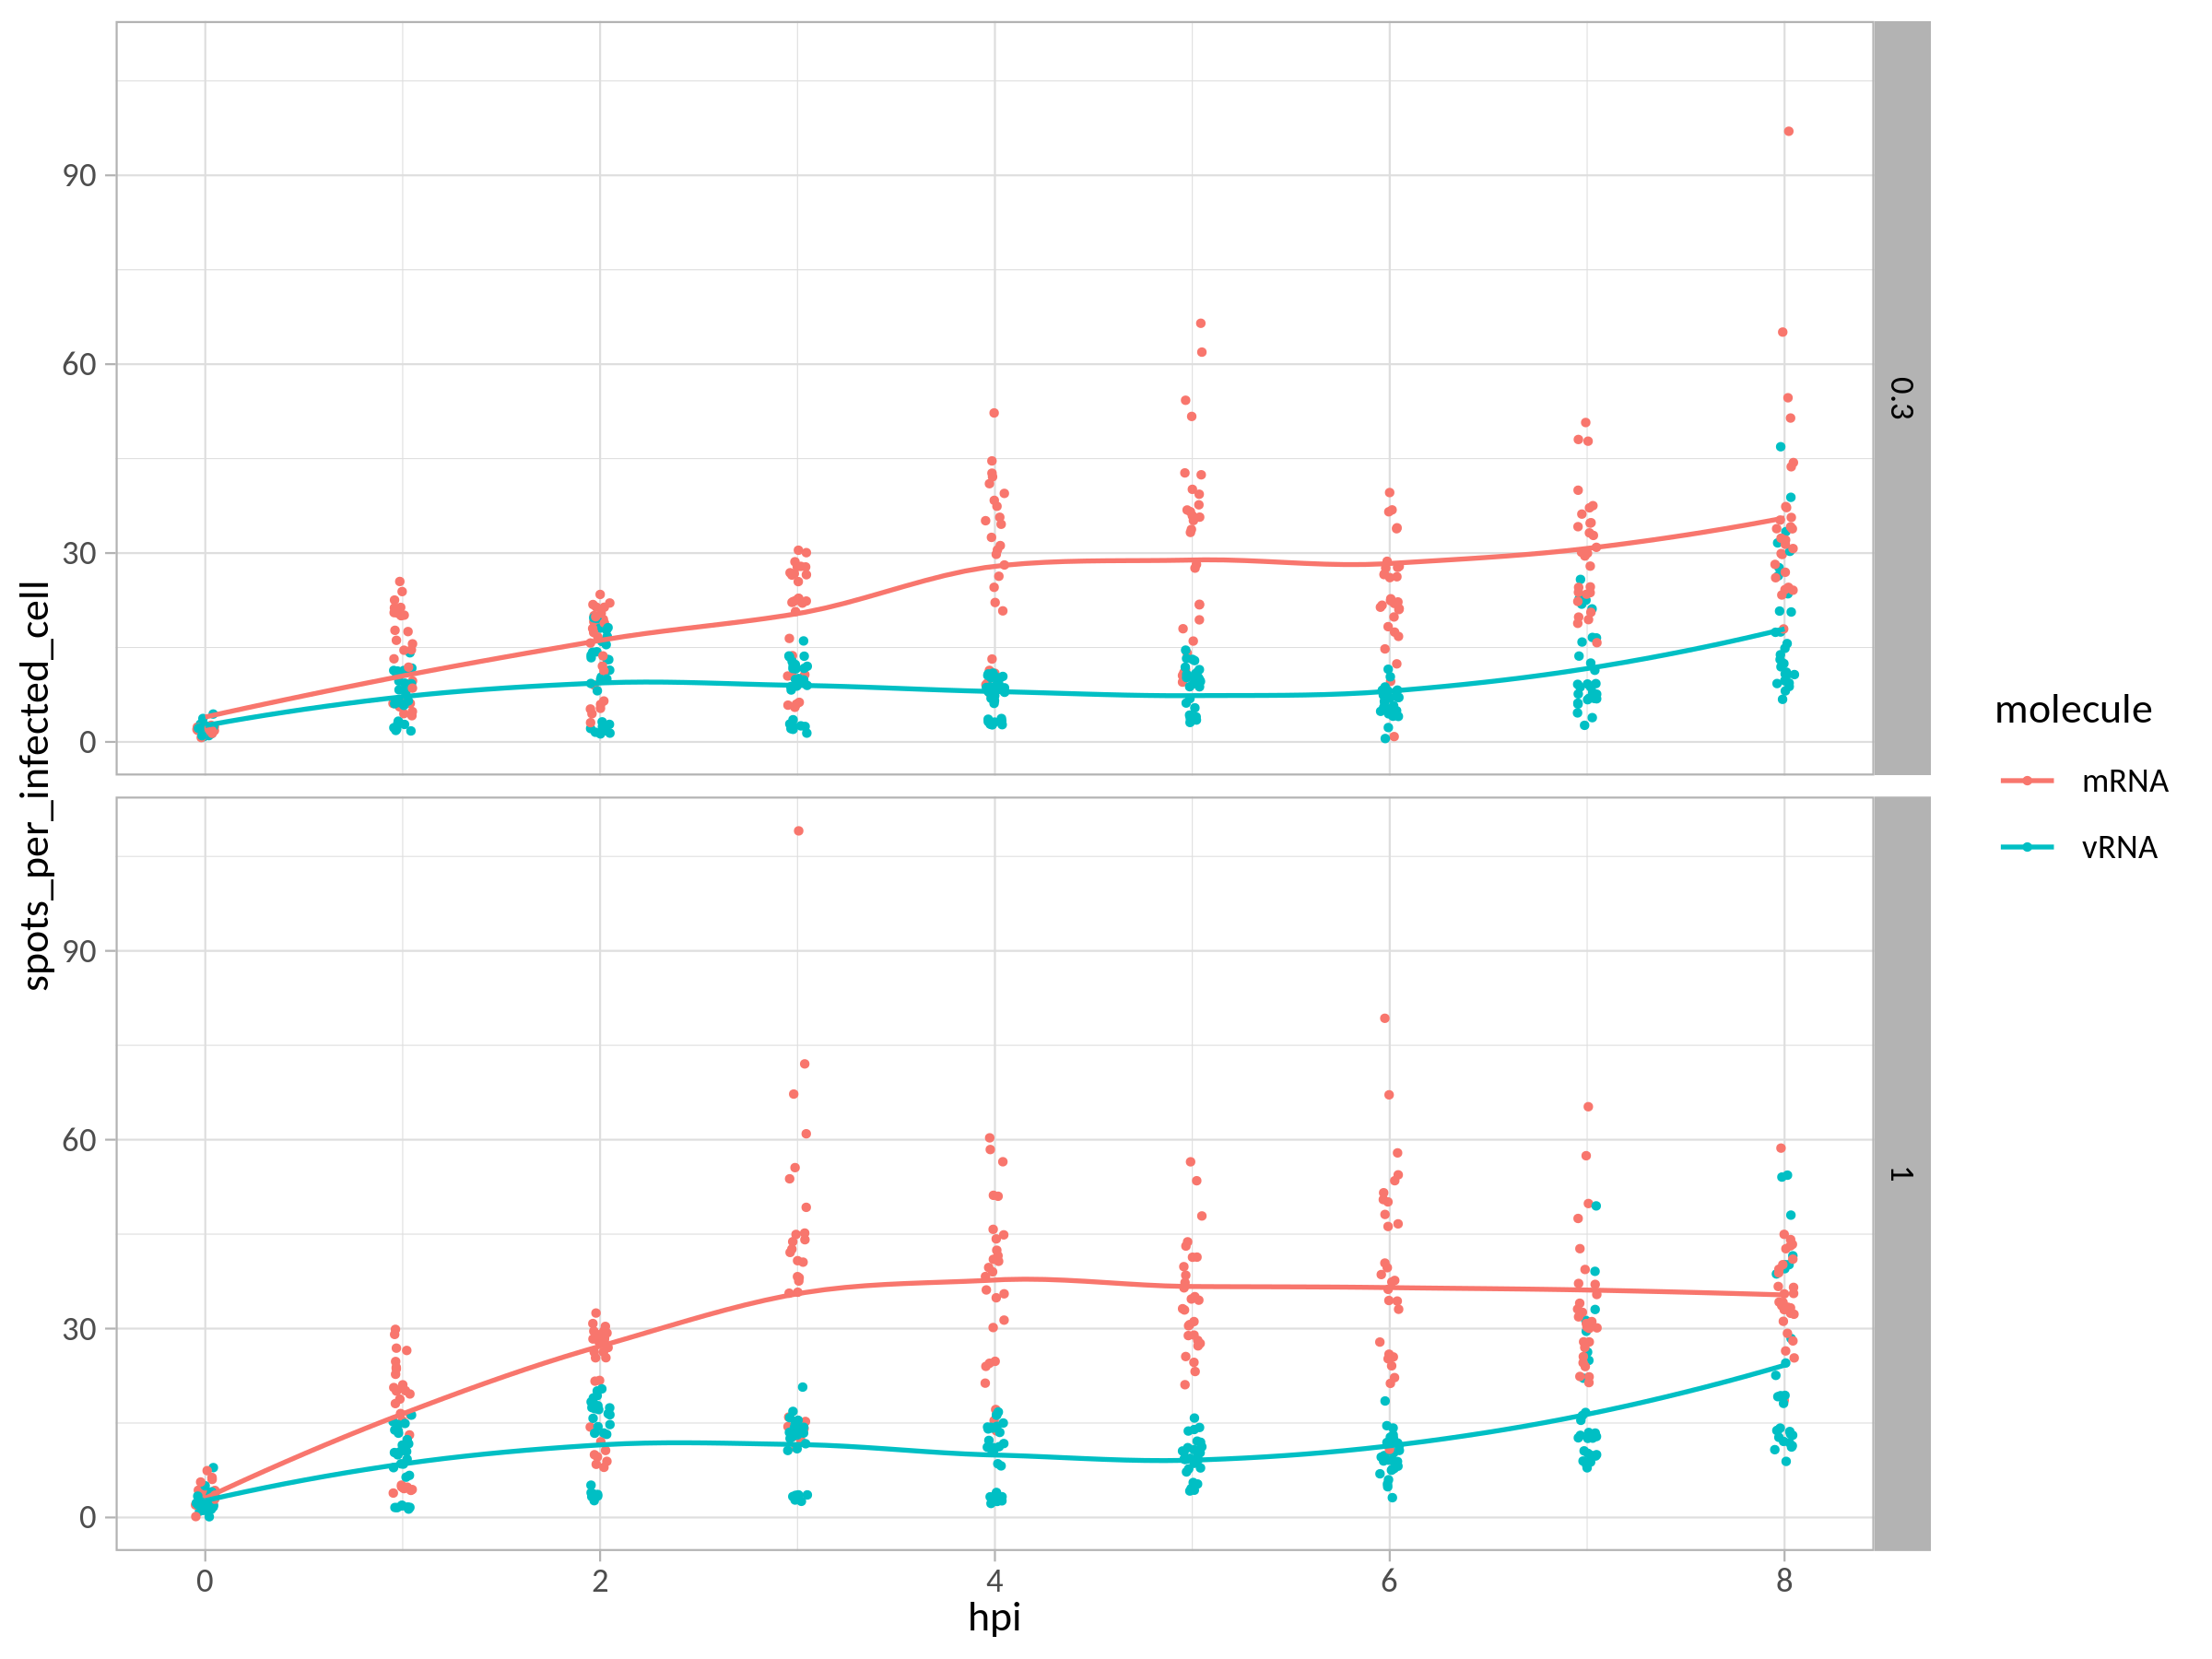

In [10]:
spots_summary %>%
  	filter(!segment %in% c("missing","multi")) %>%
	group_by(rep,moi,hpi,fov,molecule) %>%
	summarize(spots = sum(spots), spots_per_infected_cell = sum(spots_per_infected_cell)) %>%
	group_by(moi,hpi,molecule) %>%
  	mutate(mean_n = mean(spots_per_infected_cell)) %>%
  	ggplot(aes(x=hpi,y=spots_per_infected_cell,color=molecule)) +
  	#geom_jitter(aes(shape=as.factor(rep)), size=1, width=.05, height=0) +
  	geom_jitter(size=.5, width=.05, height=0) +
	geom_smooth(se=FALSE, lwd=.6, method="loess") +
  	# geom_line(aes(y=mean_n)) +
  	facet_grid(moi ~ .)

#### <a id='toc1_2_1_1_'></a>[Nucleus vs cytoplasm](#toc0_)

`summarise()` has grouped output by 'rep', 'moi', 'hpi', 'fov', 'molecule'. You
can override using the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


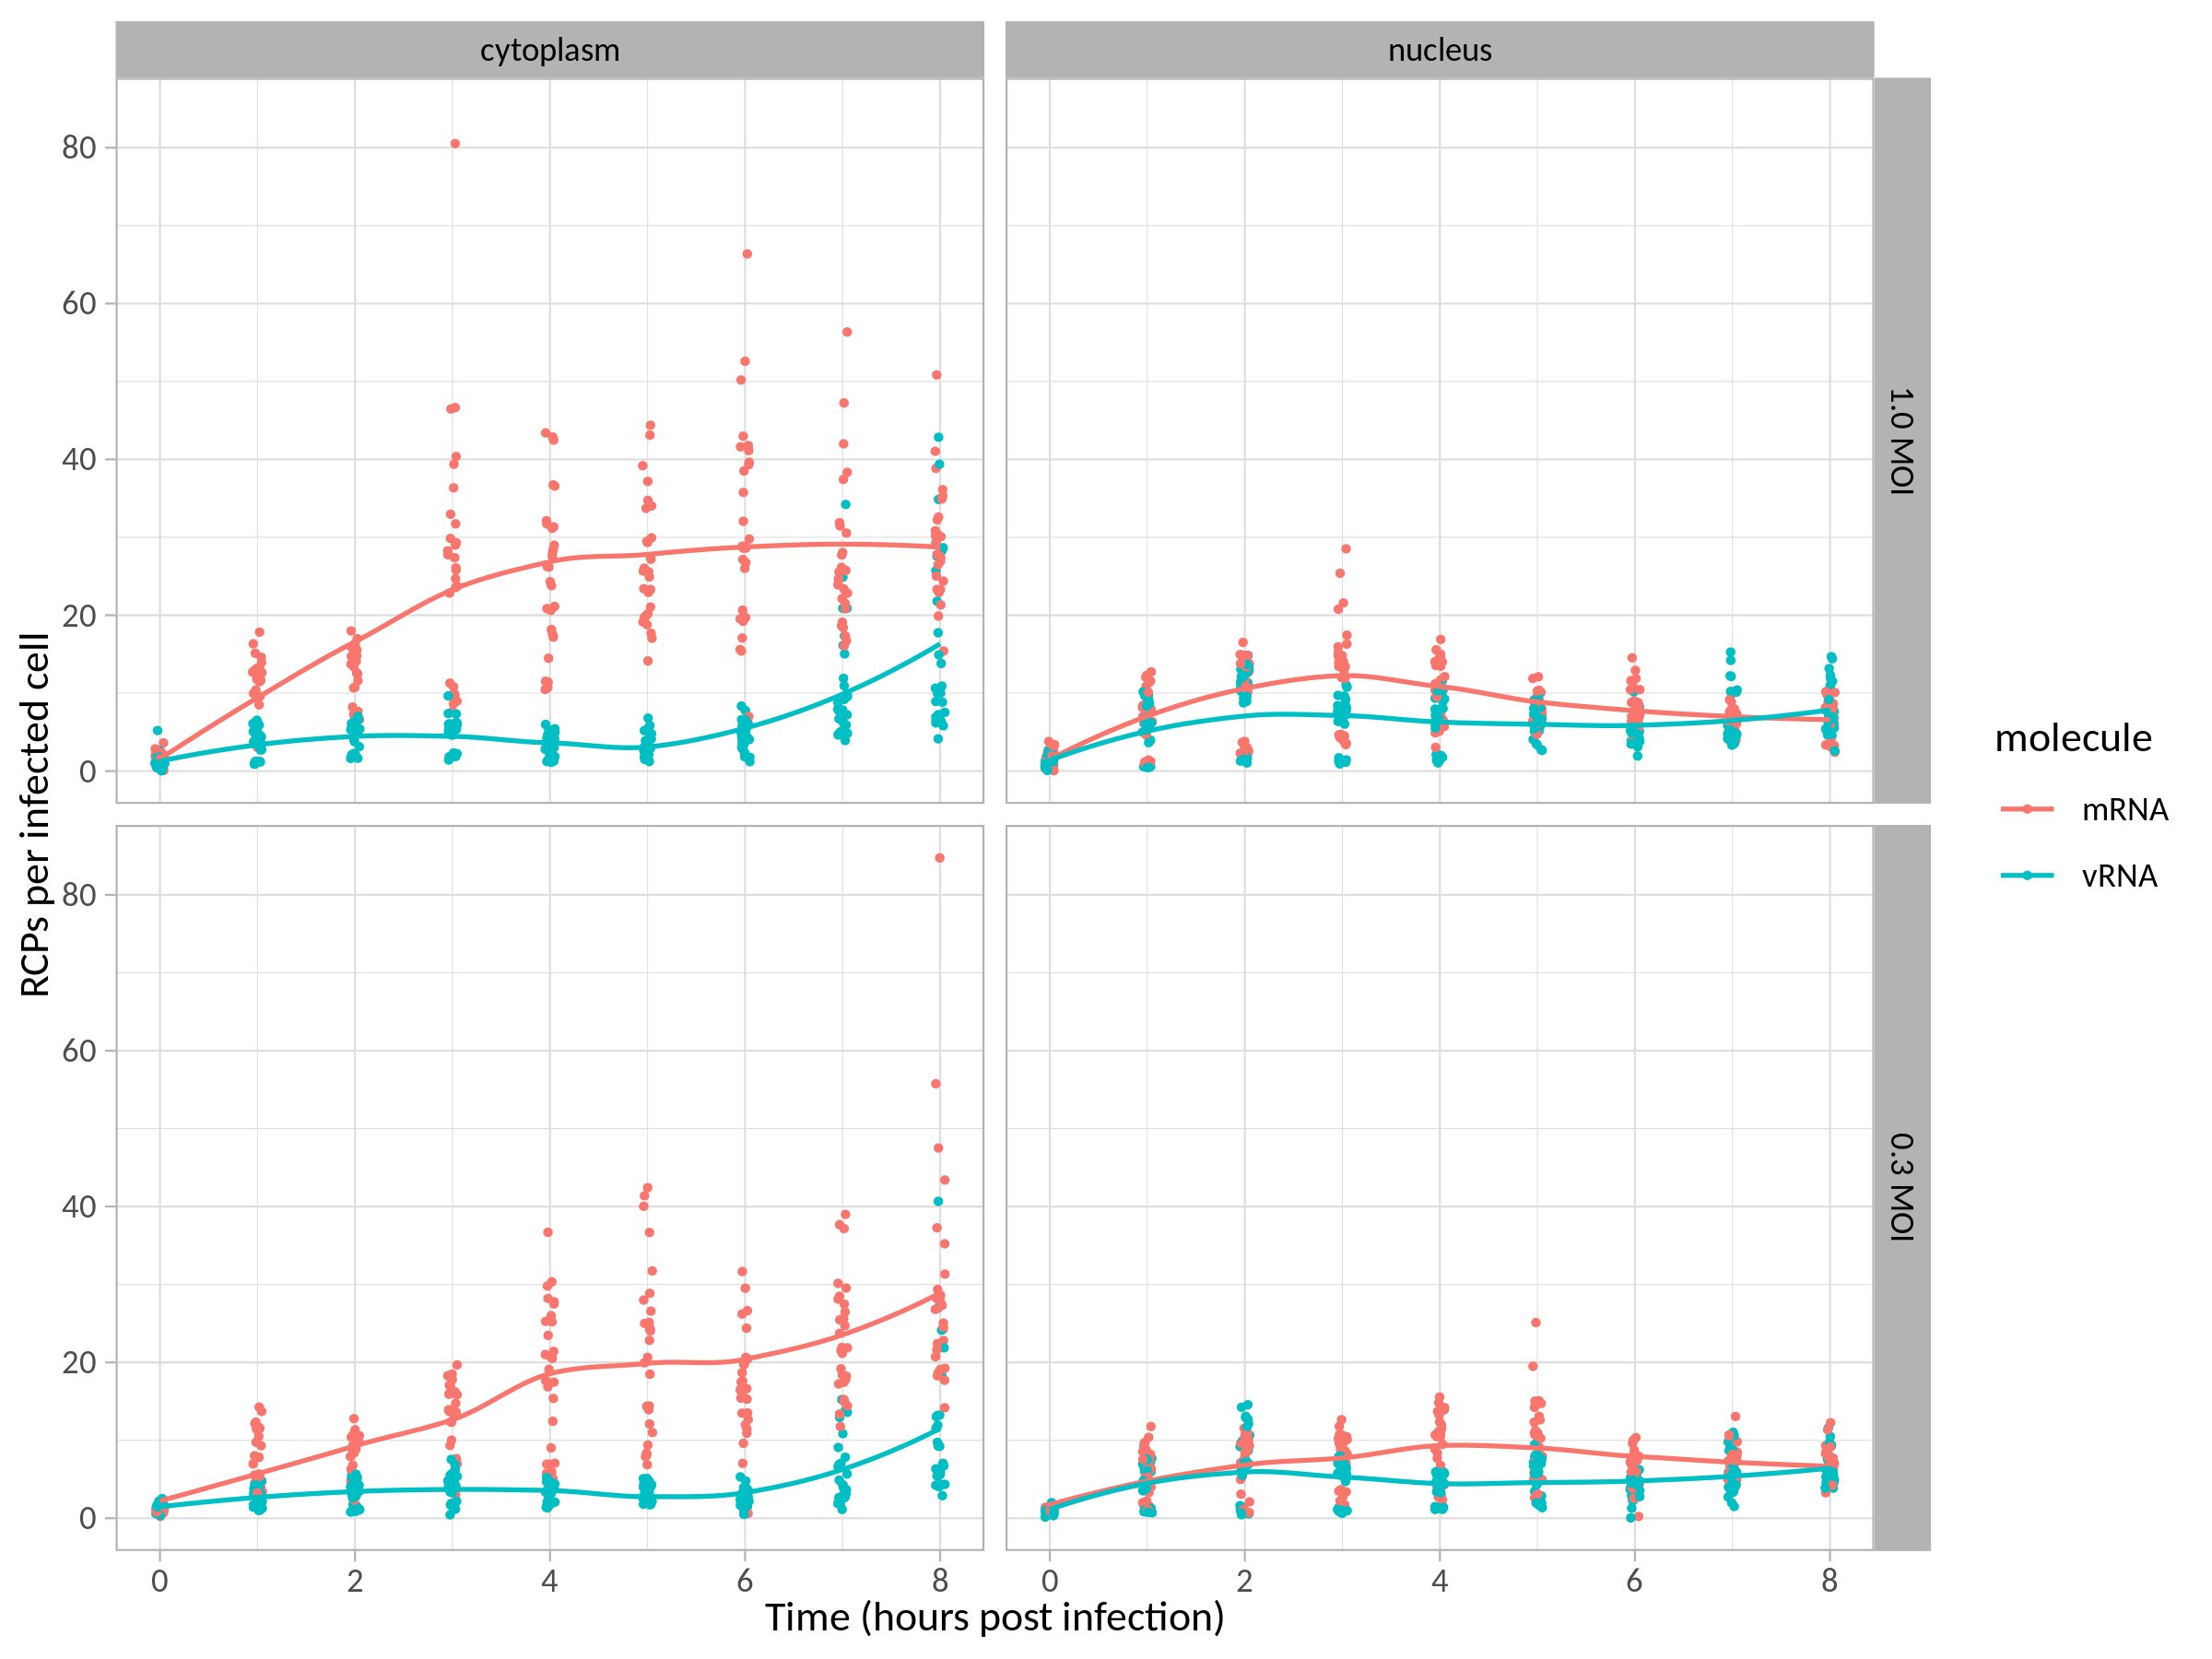

In [11]:
spots_summary_nucVScyt %>%
  filter(!segment %in% c("missing","multi")) %>%
	group_by(rep,moi,hpi,fov,molecule,nucleus) %>%
	summarize(spots = sum(spots), spots_per_infected_cell = sum(spots_per_infected_cell)) %>%
	group_by(moi,hpi,molecule) %>%
  mutate(mean_n = mean(spots_per_infected_cell)) %>%
  ungroup %>%
  mutate(moi = str_glue("{format(moi, nsmall=1)} MOI"), moi=fct_rev(moi)) %T>%
  write_tsv("figures/fig5c-molecule_abundance.tsv") %>%
  ggplot(aes(x=hpi,y=spots_per_infected_cell,color=molecule)) +
  	geom_jitter(size=.5, width=.05, height=0) +
    geom_smooth(se=FALSE, lwd=.6, method="loess") +
    xlab("Time (hours post infection)") +
    ylab("RCPs per infected cell") +
  	facet_grid(moi ~ nucleus)

In [12]:
ggsave("figures/fig5c-molecule_abundance.svg", width = 8, height = 6, dpi = 300)

`geom_smooth()` using formula = 'y ~ x'


### <a id='toc1_2_2_'></a>[Separate reps](#toc0_)

`summarise()` has grouped output by 'rep', 'moi', 'hpi', 'fov'. You can
override using the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


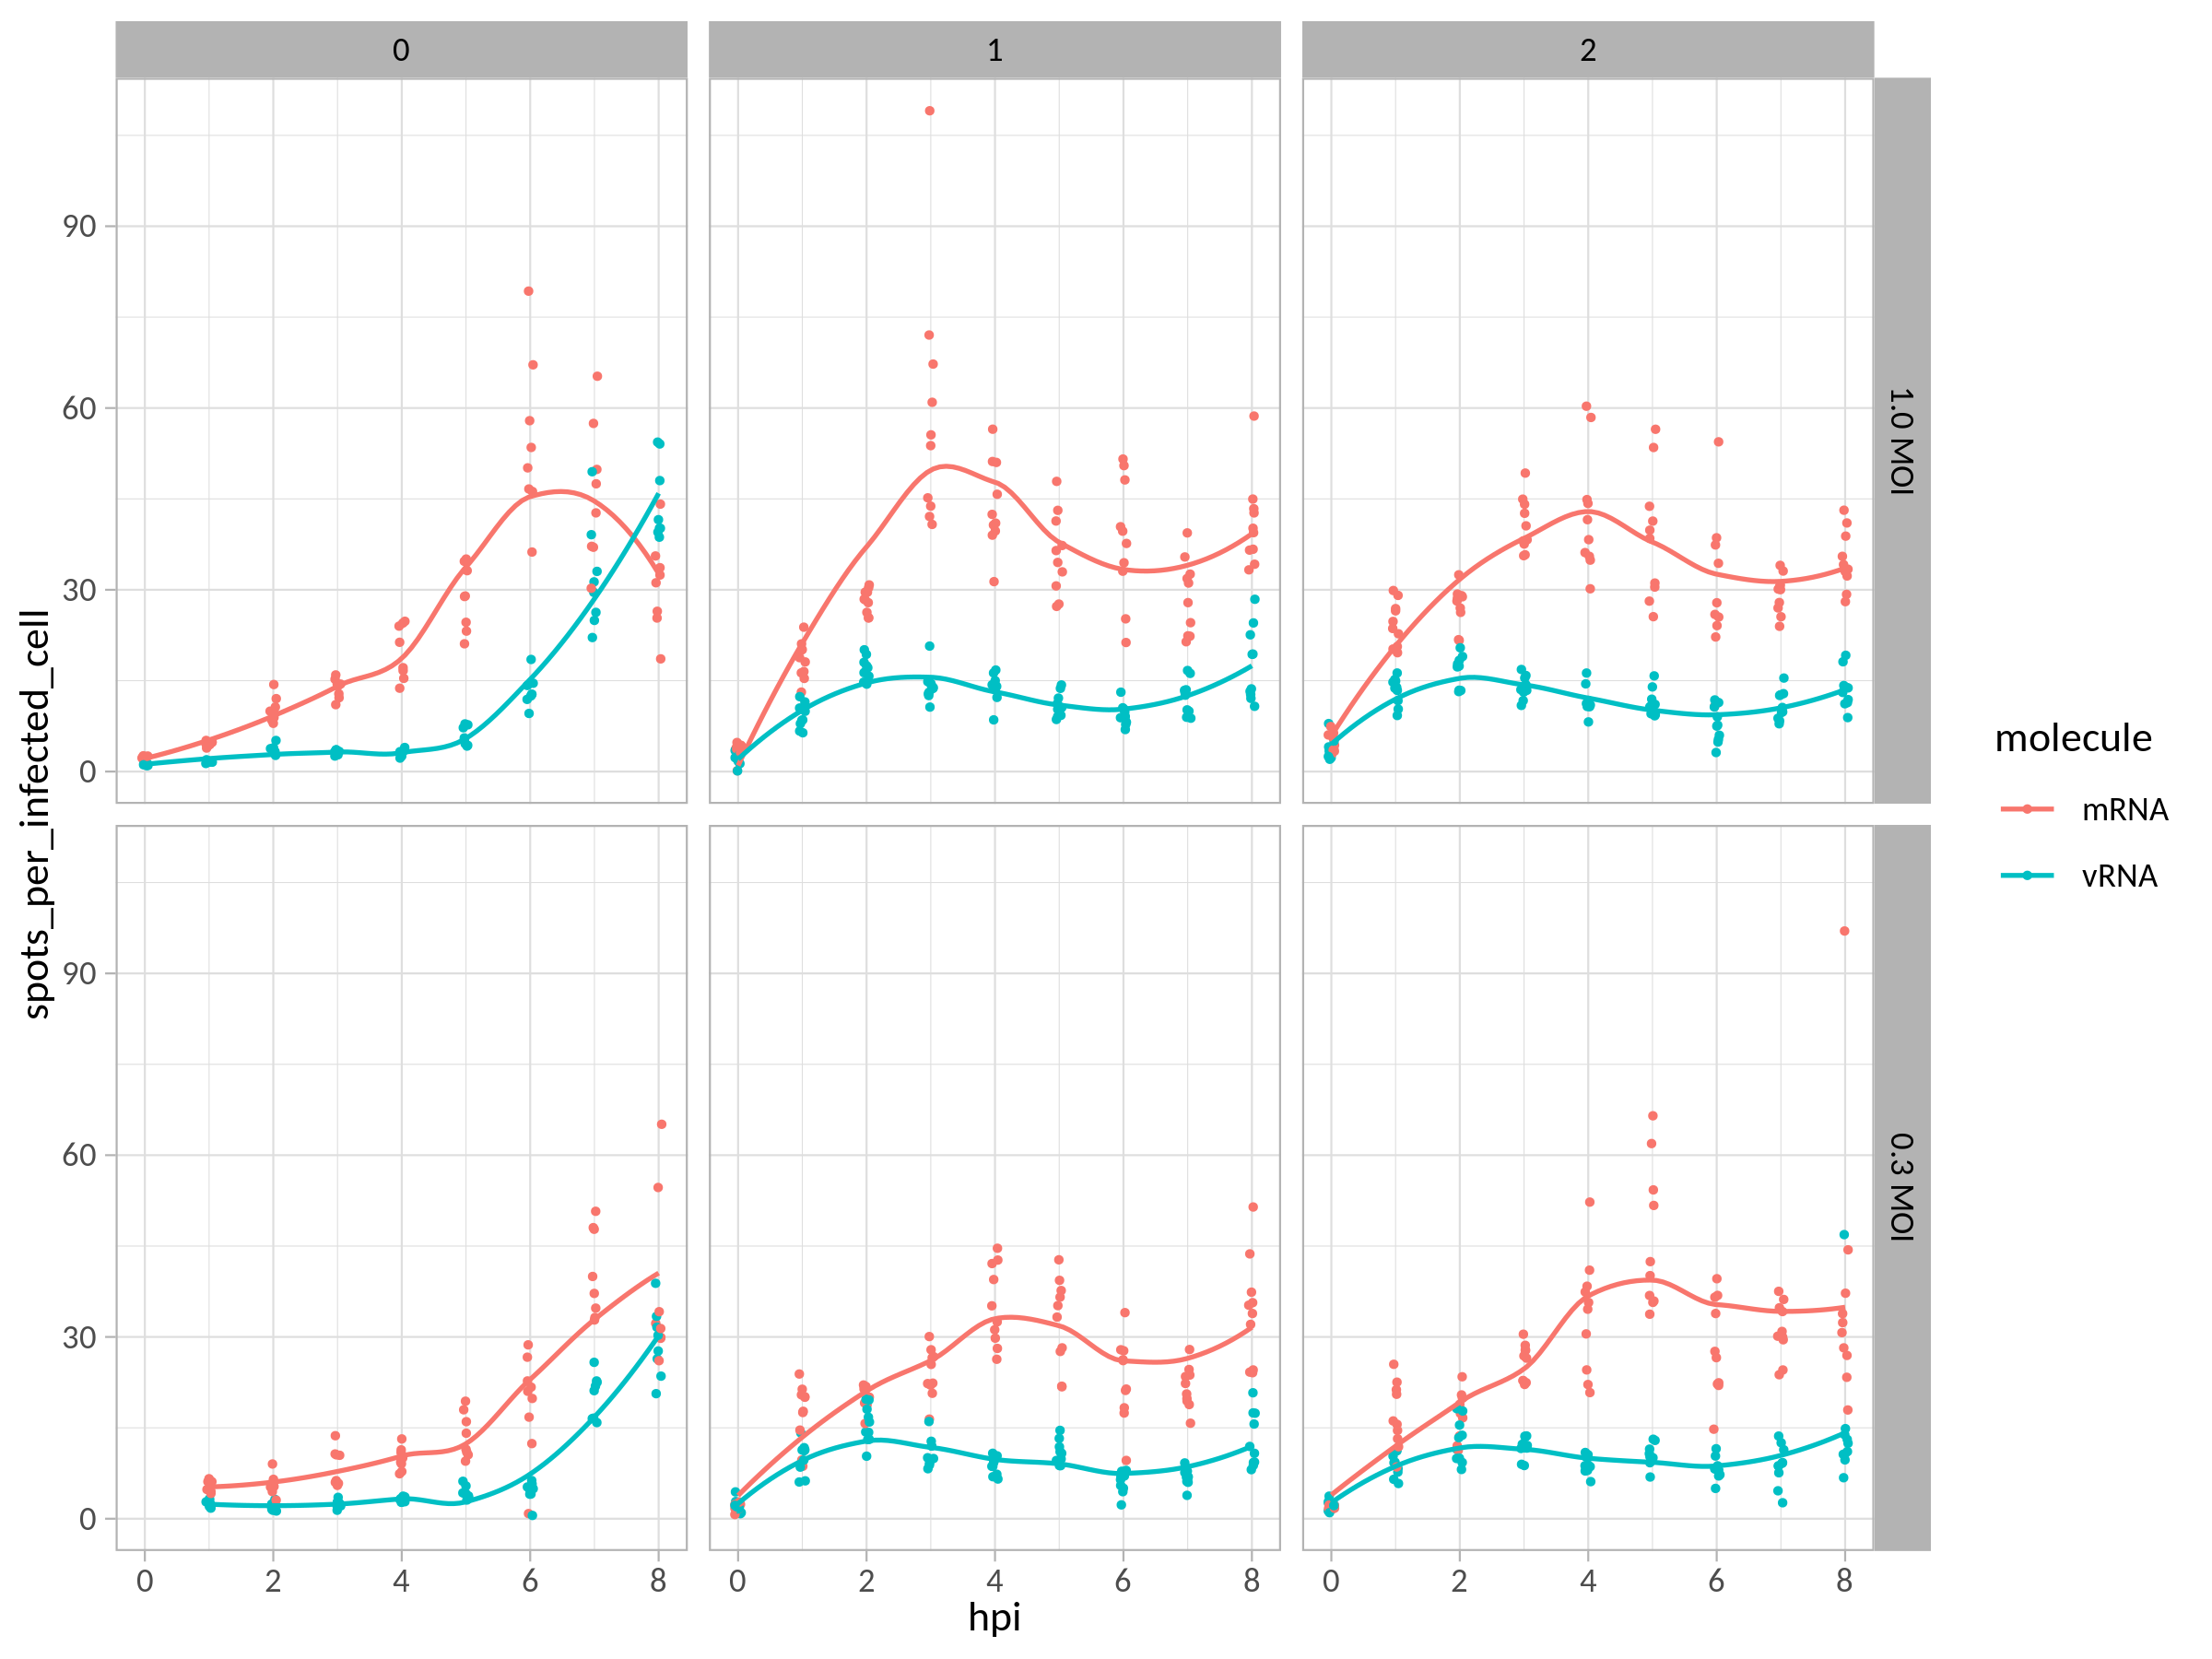

In [13]:
spots_summary %>%
  filter(!segment %in% c("missing","multi")) %>%
	group_by(rep,moi,hpi,fov,molecule) %>%
	summarize(spots = sum(spots), spots_per_infected_cell = sum(spots_per_infected_cell)) %>%
	group_by(moi,hpi,molecule) %>%
  mutate(mean_n = mean(spots_per_infected_cell)) %>%
  ungroup %>%
  mutate(moi = str_glue("{format(moi, nsmall=1)} MOI"), moi=fct_rev(moi)) %>%
  ggplot(aes(x=hpi,y=spots_per_infected_cell,color=molecule)) +
  	geom_jitter(size=.5, width=.05, height=0) +
    geom_smooth(se=FALSE, lwd=.6, method="loess") +
  	facet_grid(moi ~ rep)

## <a id='toc1_3_'></a>[Absolute segment abundance over time](#toc0_)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


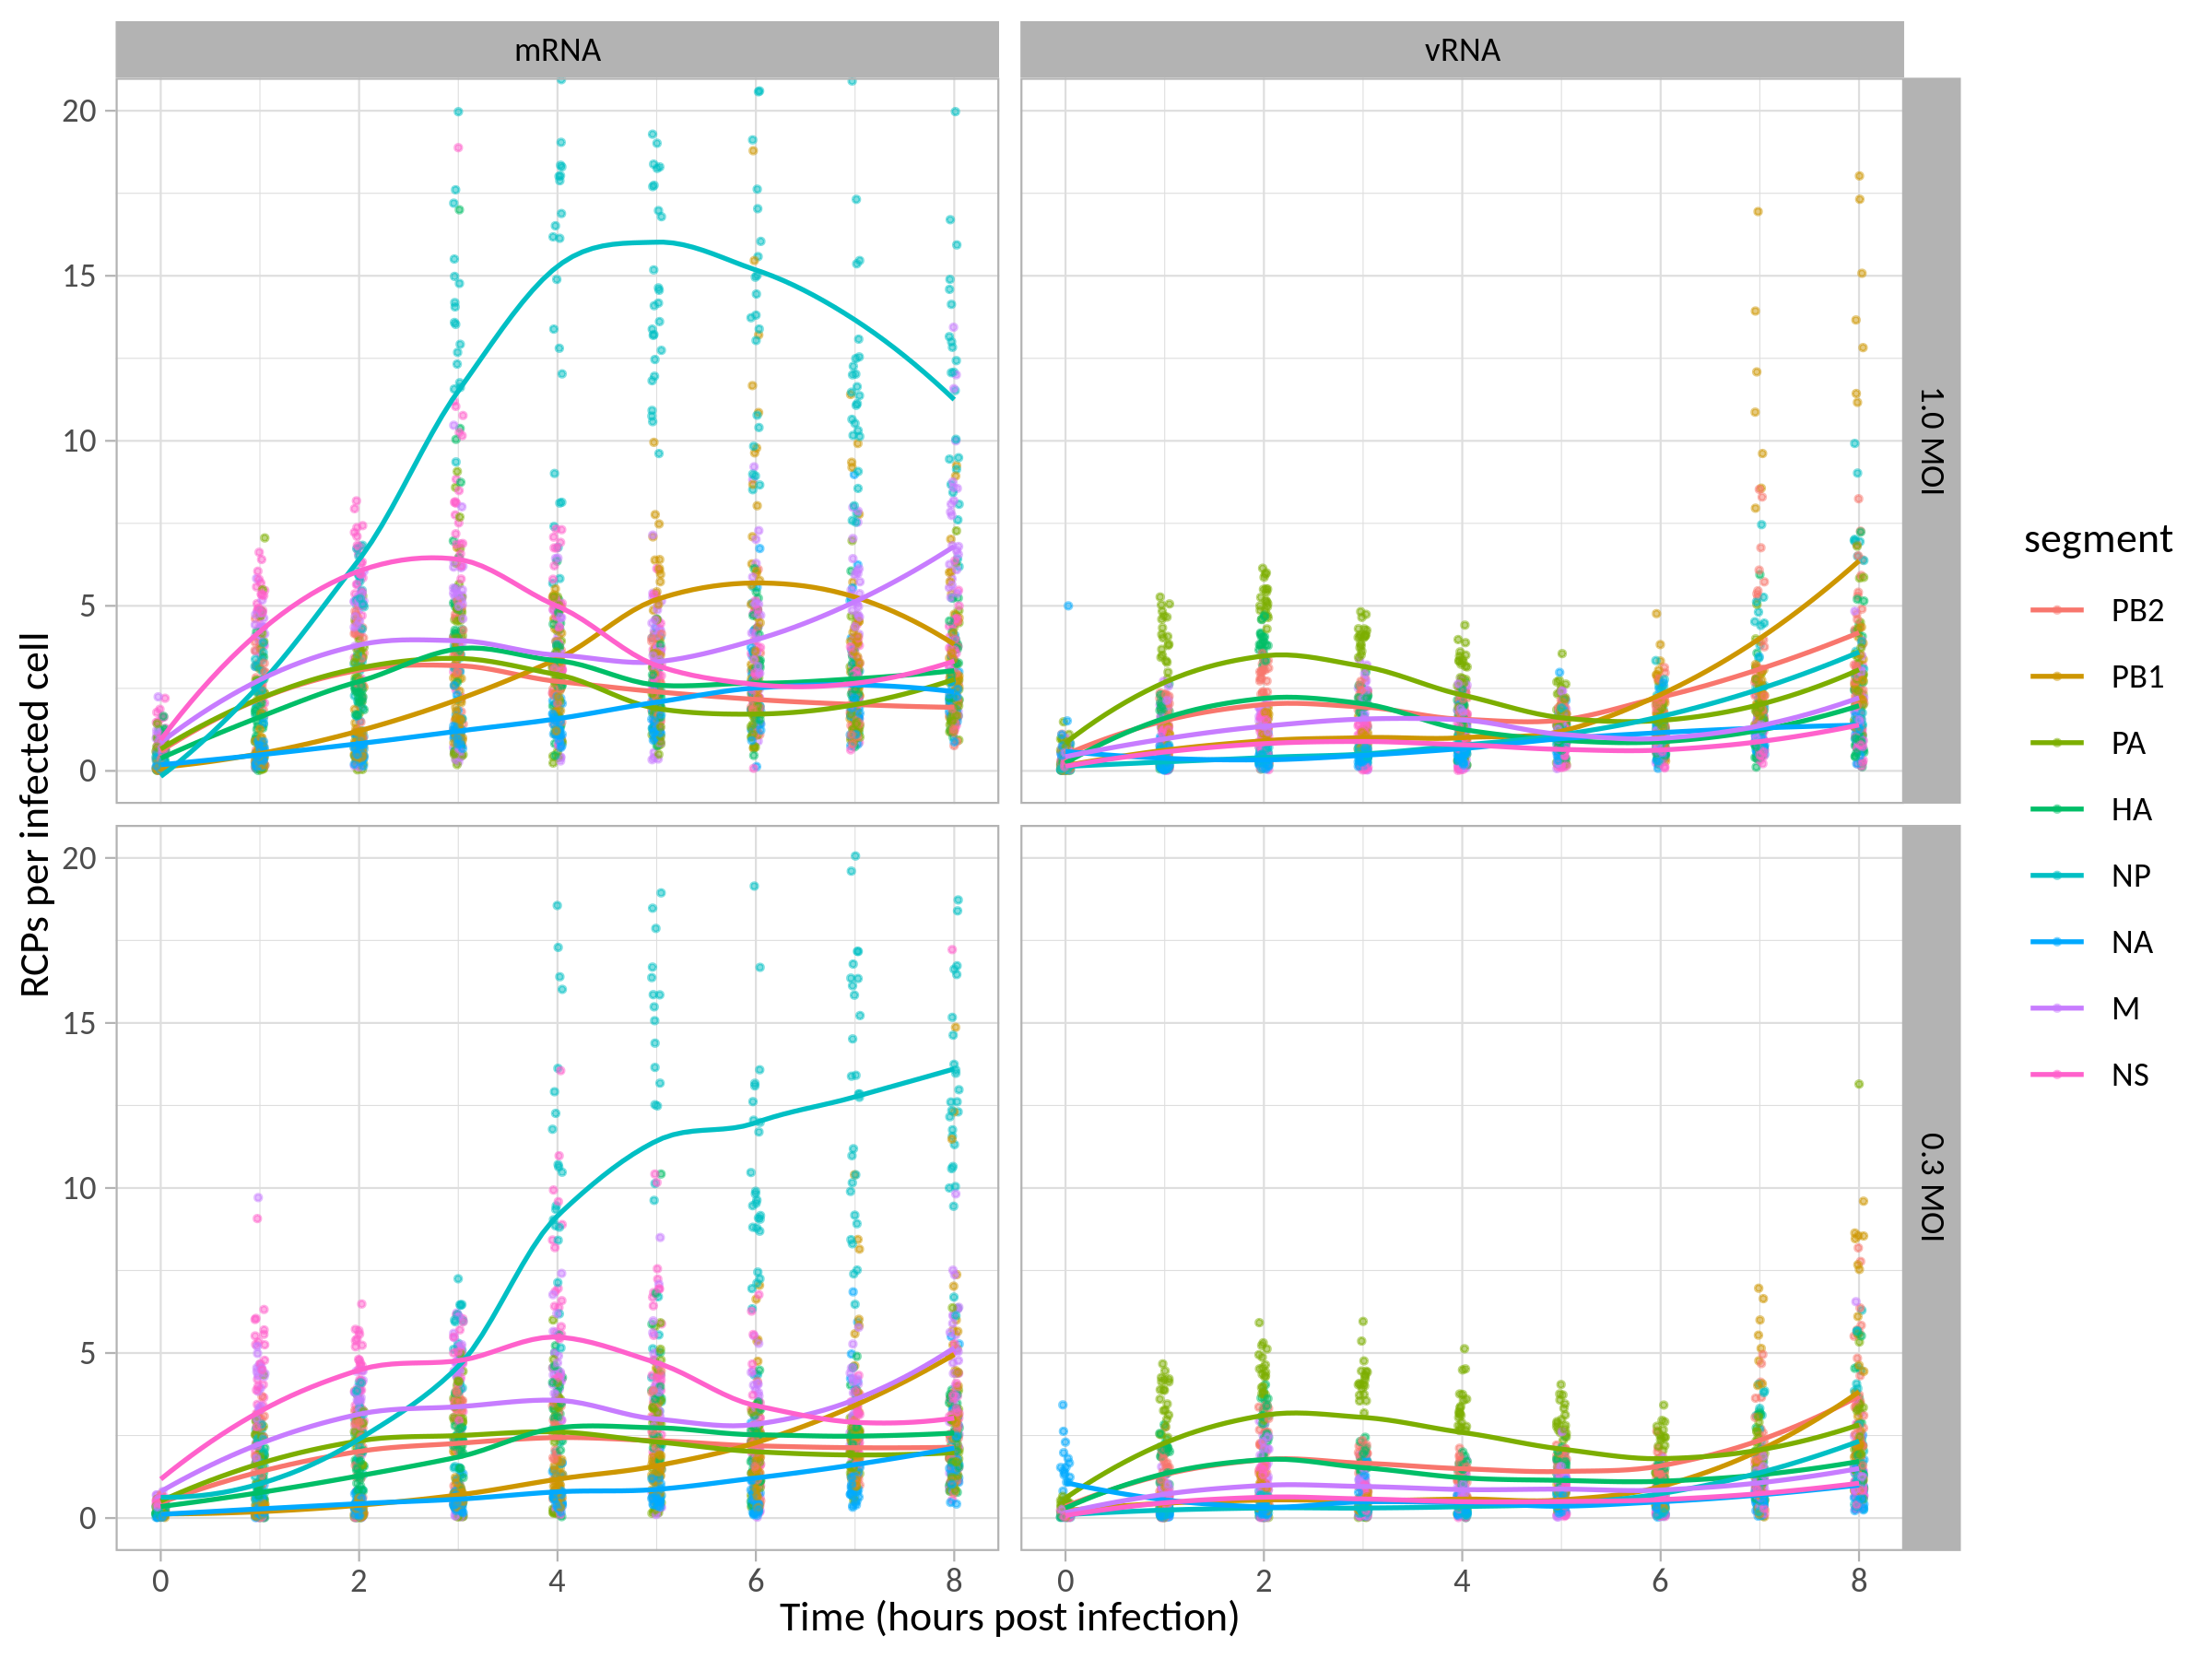

In [14]:
spots_summary %>%
	group_by(moi,hpi,segment,molecule) %>%
  mutate(mean_n = mean(spots_per_infected_cell)) %>%
  filter(!segment %in% c("missing","multi")) %>%
  ungroup %>% 
  mutate(moi = str_glue("{format(moi, nsmall=1)} MOI"), moi=fct_rev(moi)) %T>%
  write_tsv("figures/fig5d-segment_abundance.tsv") %>%
  ggplot(aes(x=hpi,y=spots_per_infected_cell,color=segment)) +
  	geom_jitter(size=.5, width=.05, height=0, alpha=.5) +
	  geom_smooth(se=FALSE, lwd=.6) +
  	facet_grid(moi ~ molecule) +
    coord_cartesian(ylim=c(0,20)) +
    xlab("Time (hours post infection)") +
    ylab("RCPs per infected cell") +
    NULL

In [15]:
ggsave("figures/fig5d-segment_abundance.svg", width = 8, height = 6, dpi = 300)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


⚠️ Not all data points are shown by restricting the y-axis to 0-20 (only points up to 21 are visible). The number of omitted points are:

In [16]:
spots_summary %>%
	group_by(moi,hpi,segment,molecule) %>%
  	mutate(mean_n = mean(spots_per_infected_cell)) %>%
  	filter(!segment %in% c("missing","multi")) %>%
    filter(spots_per_infected_cell>21) %>%
    ungroup %>%
    count(moi, molecule, segment)

moi,molecule,segment,n
<dbl>,<chr>,<fct>,<int>
0.3,mRNA,NP,6
0.3,mRNA,M,1
1.0,mRNA,NP,20
1.0,vRNA,PB1,1


This is how the plot looks with axes covering the full range. Including the few previously omitted points impedes interpretability of the figure.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


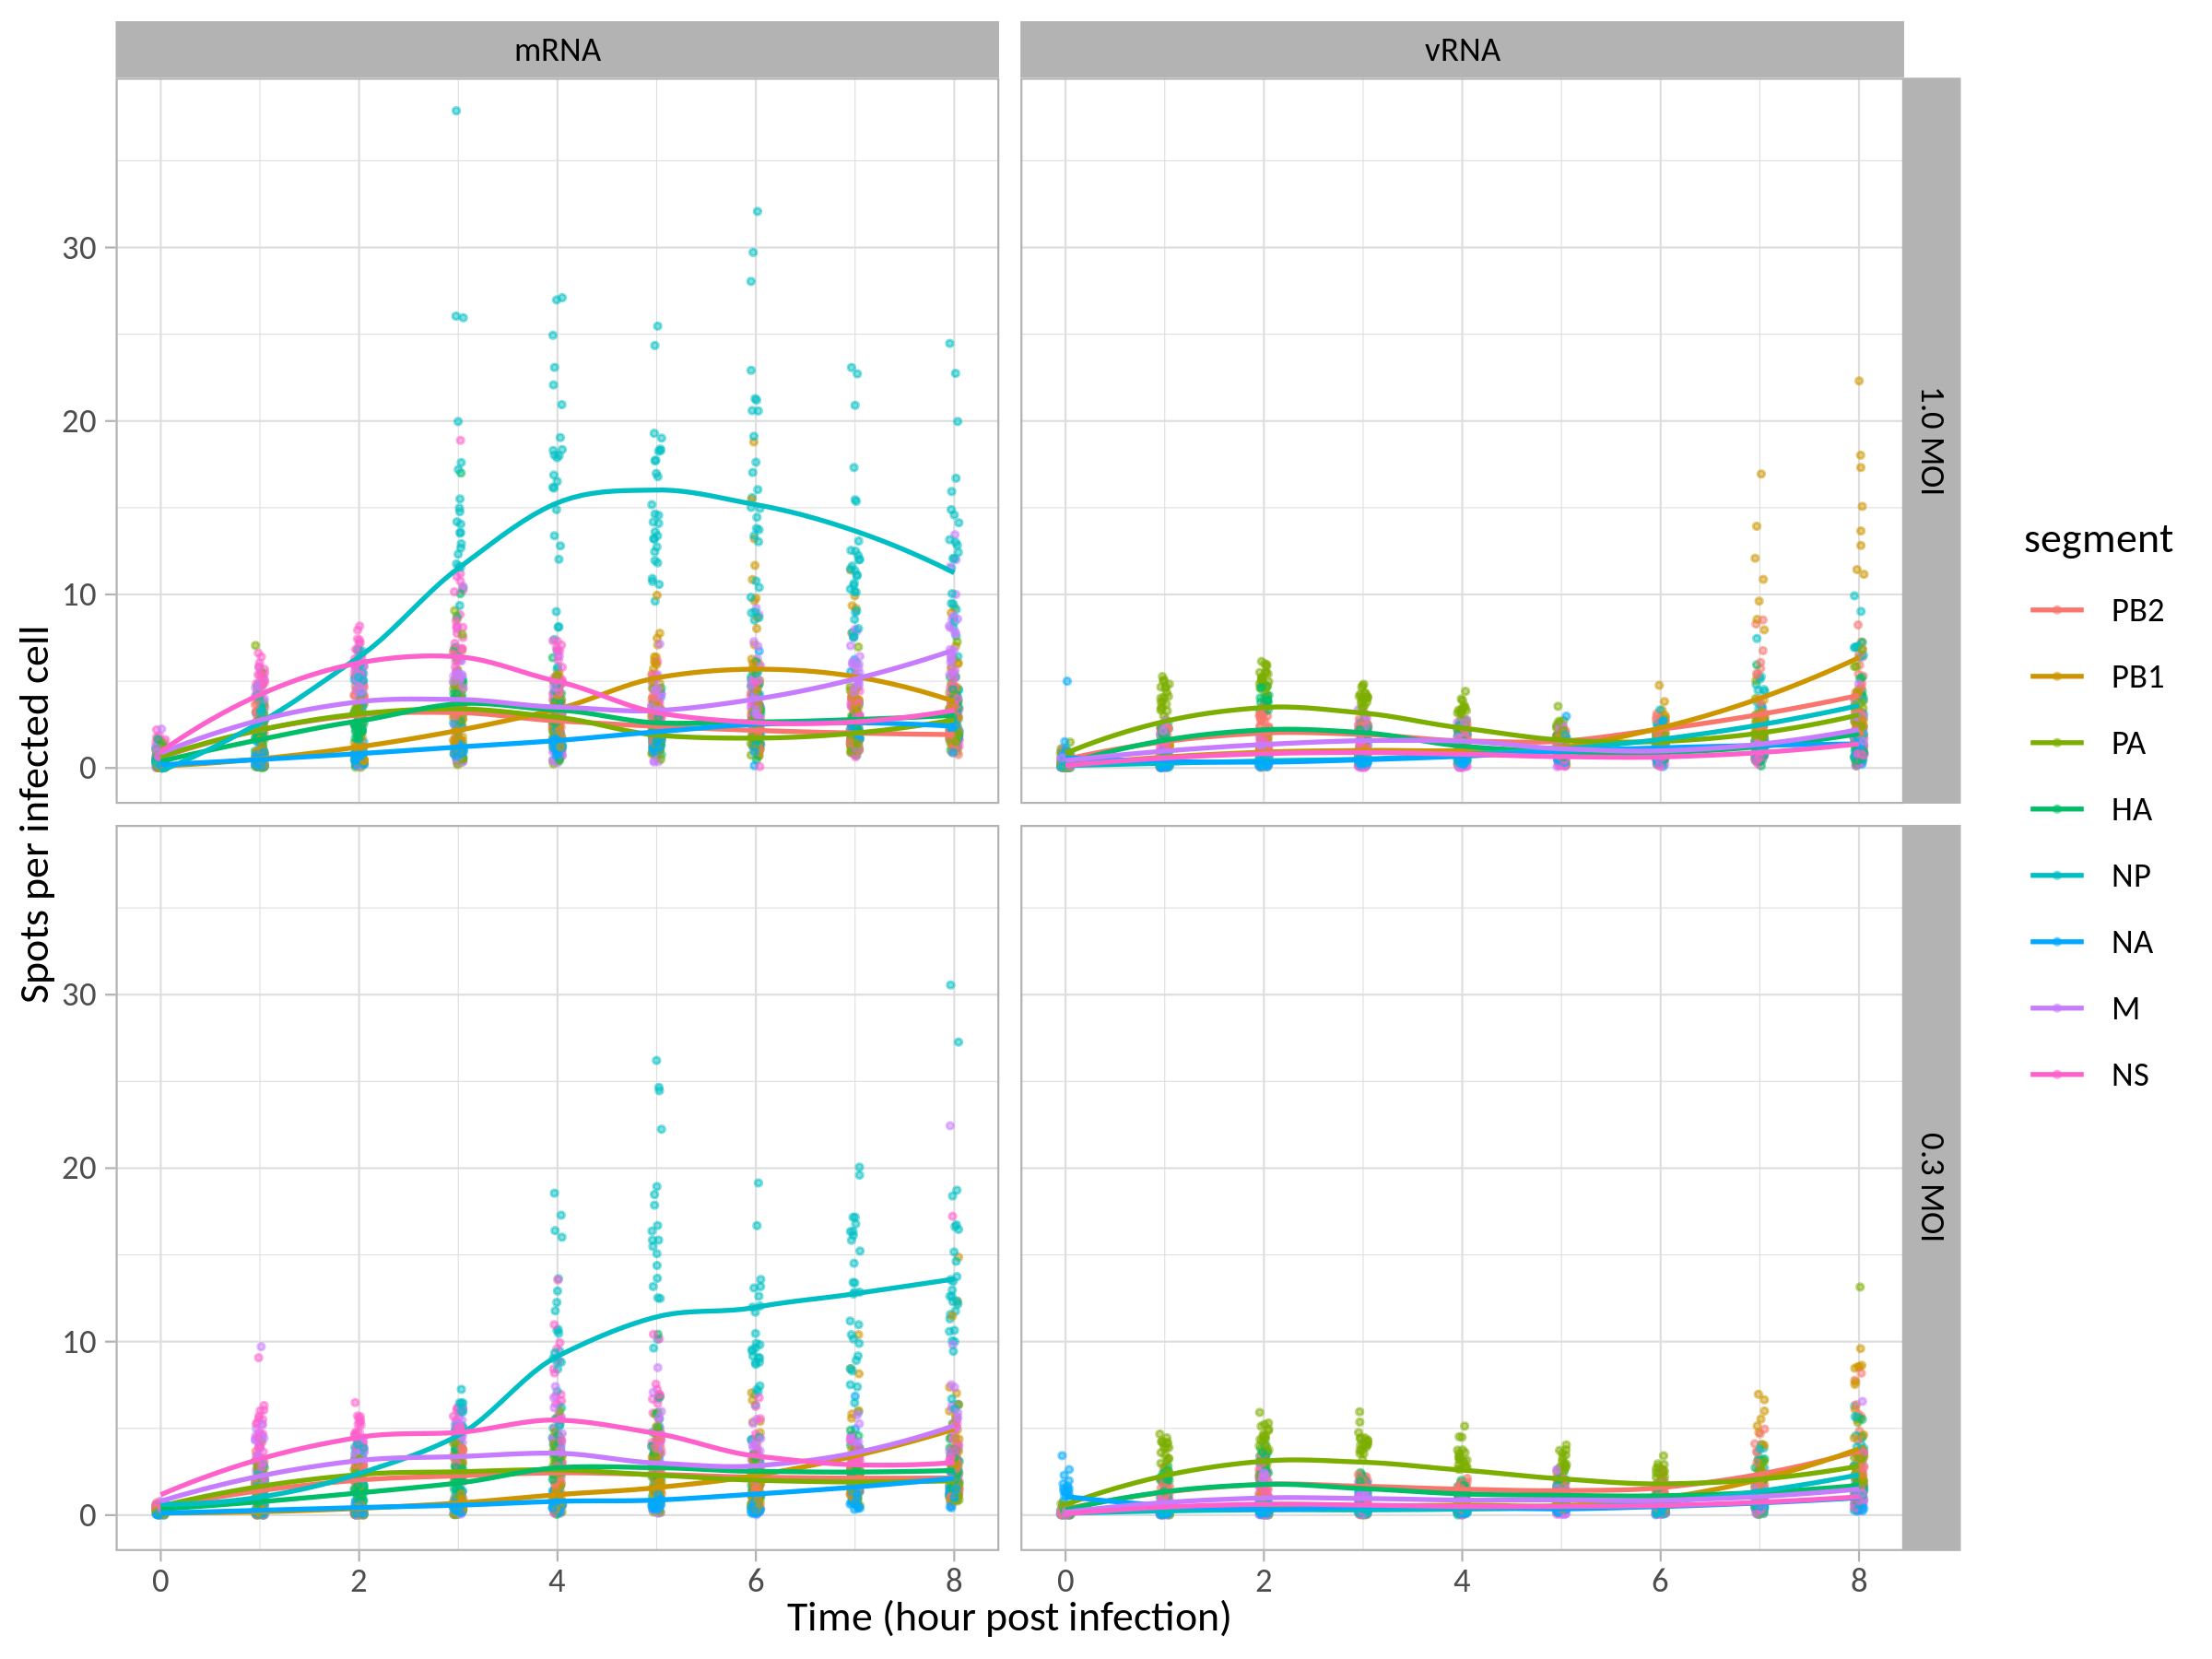

In [17]:
spots_summary %>%
	group_by(moi,hpi,segment,molecule) %>%
  mutate(mean_n = mean(spots_per_infected_cell)) %>%
  filter(!segment %in% c("missing","multi")) %>%
  ungroup %>% 
  mutate(moi = str_glue("{format(moi, nsmall=1)} MOI"), moi=fct_rev(moi)) %>%
  ggplot(aes(x=hpi,y=spots_per_infected_cell,color=segment)) +
  	geom_jitter(size=.5, width=.05, height=0, alpha=.5) +
	  geom_smooth(se=FALSE, lwd=.6) +
  	facet_grid(moi ~ molecule) +
    xlab("Time (hour post infection)") +
    ylab("Spots per infected cell") +
    NULL

## <a id='toc1_4_'></a>[Relative segment abundance over time](#toc0_)

### <a id='toc1_4_1_'></a>[1.0 MOI](#toc0_)

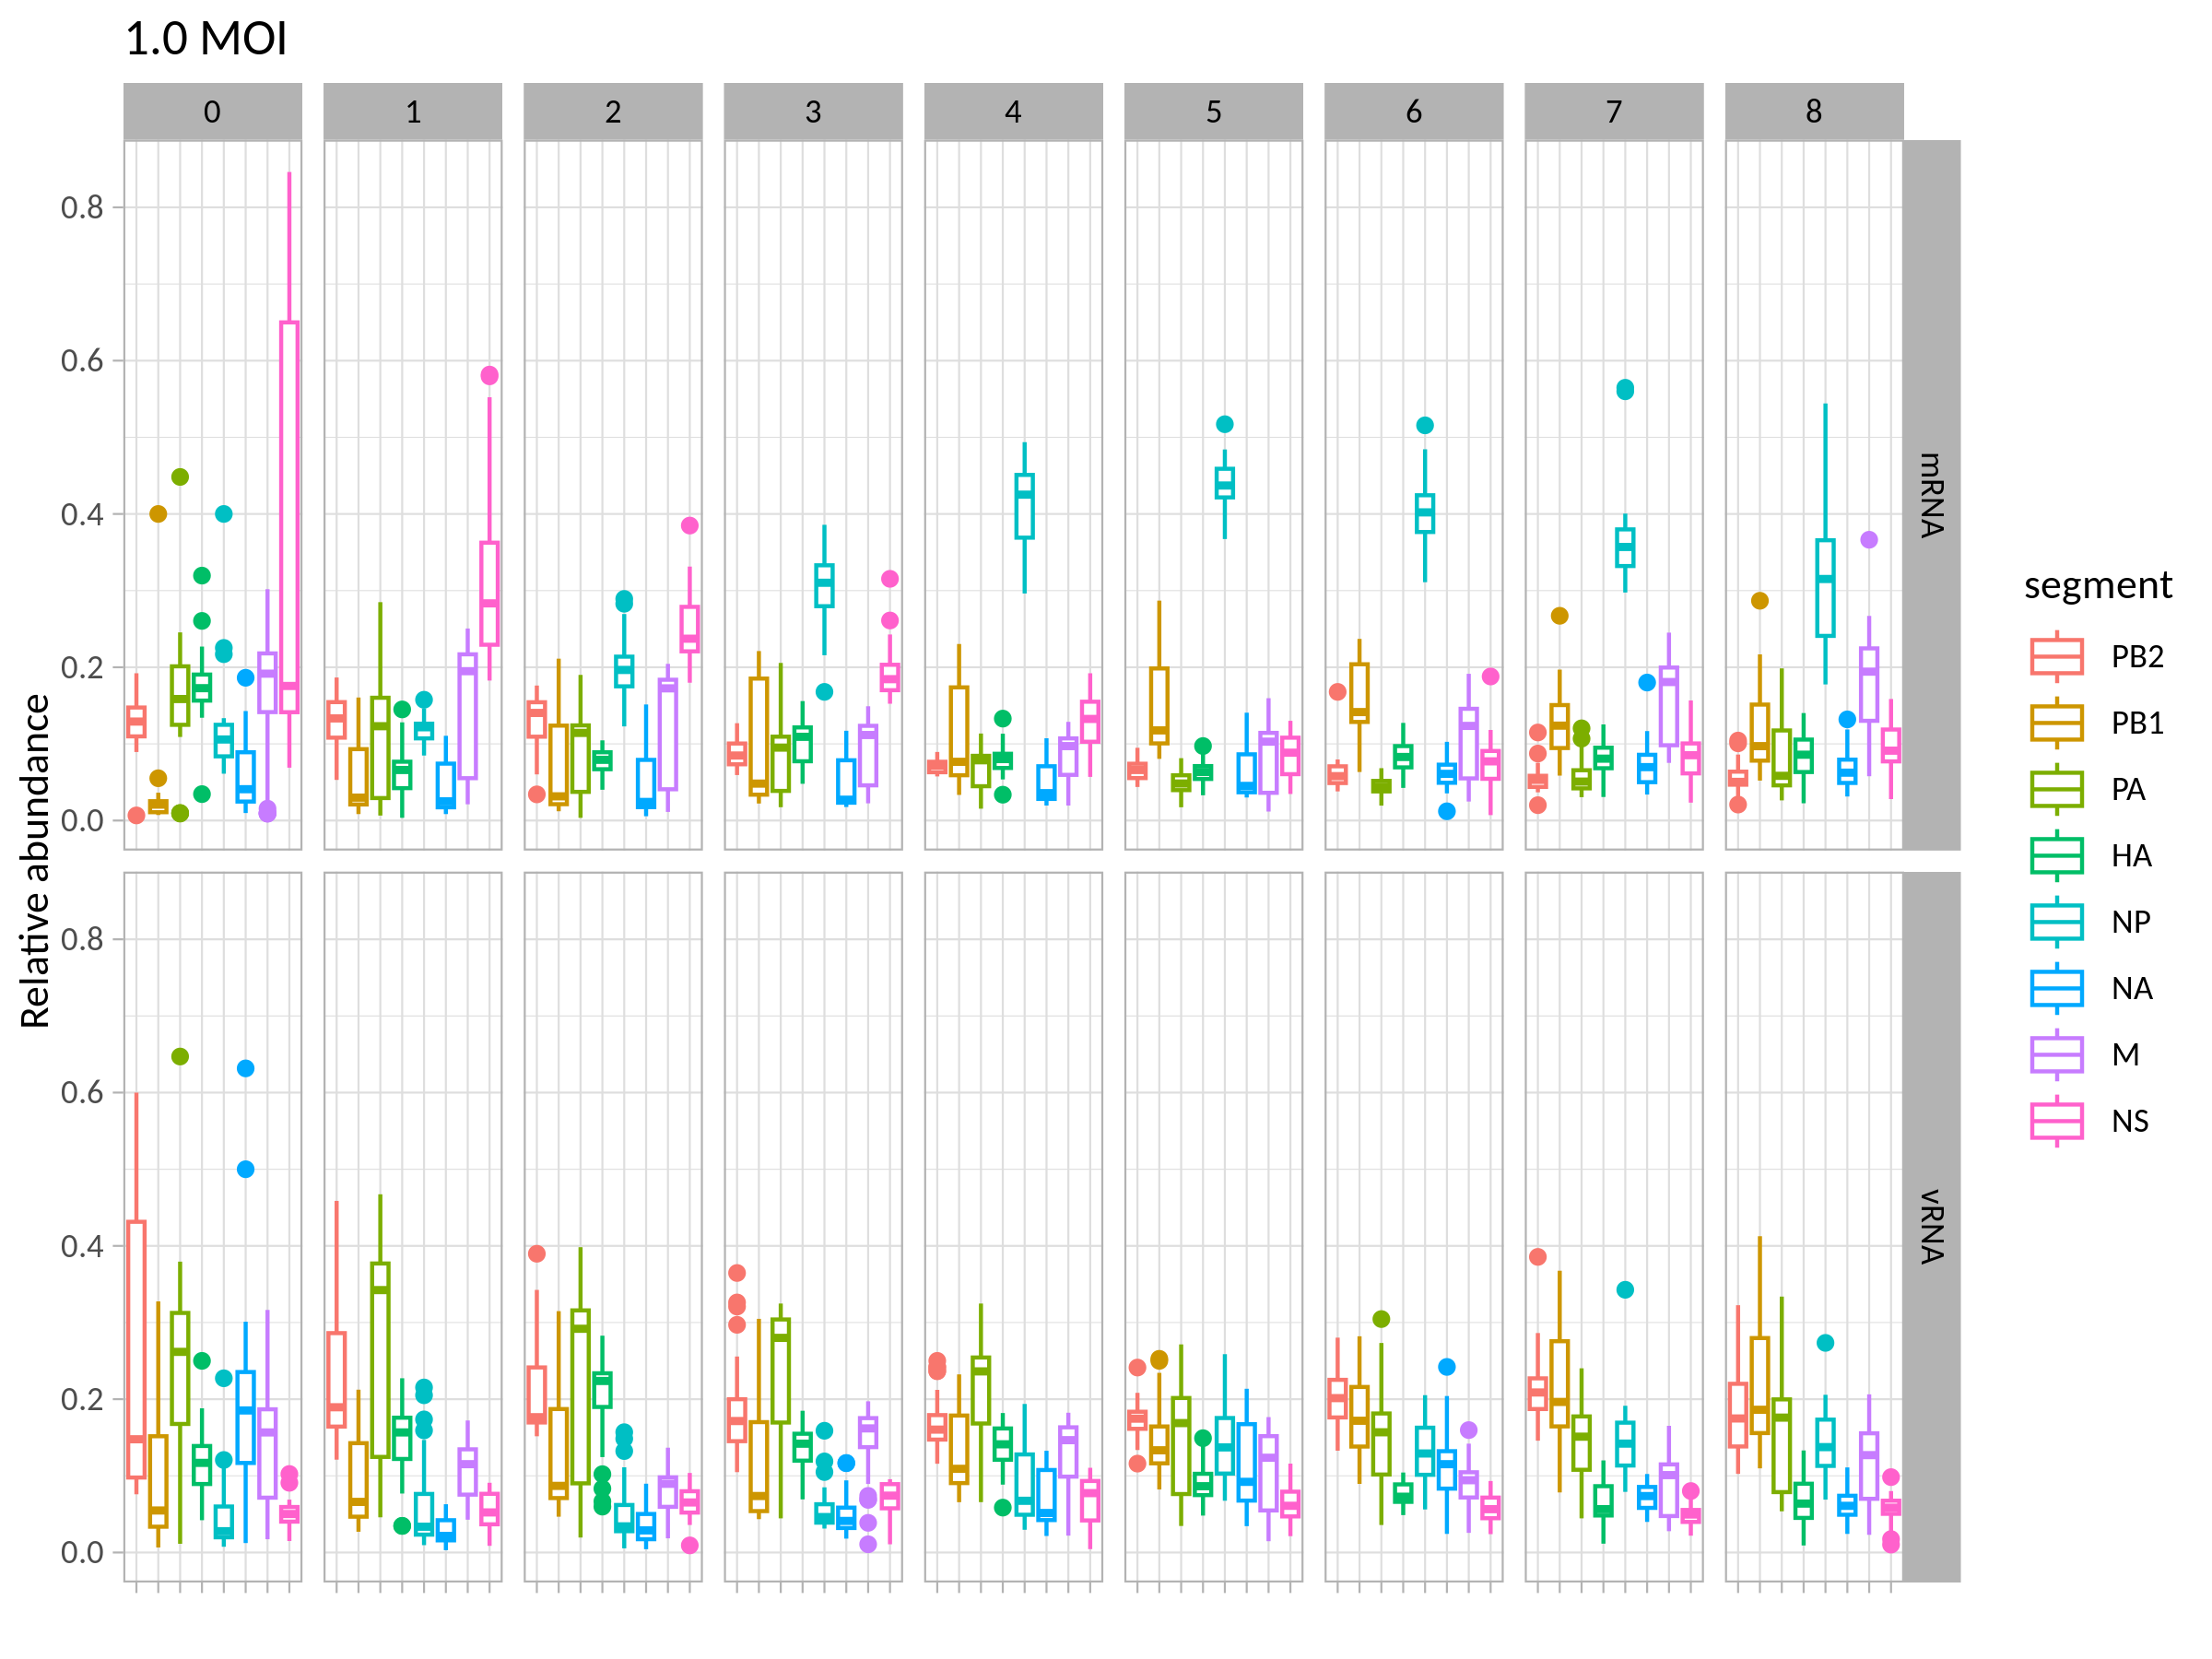

In [18]:
spots_summary %>%
	group_by(rep, moi, hpi, fov, molecule) %>%
	mutate(relative_abundance = spots_per_infected_cell/sum(spots_per_infected_cell)) %>%
	ungroup() %>%
	filter(moi==1.0, !is.na(molecule)) %>%
	mutate(segment = fct_relevel(segment, segment_order)) %>%
	ggplot(aes(x=segment, color=segment, y=relative_abundance)) +
		geom_boxplot() +
		facet_grid(molecule ~ hpi) +
		#geom_hline(yintercept=1/8, lty=2, lwd=.3) +
		theme(axis.text.x = element_blank()) +
		ggtitle("1.0 MOI") +
    ylab("Relative abundance") +
    xlab("")

In [19]:
ggsave("figures/supp-fig7a-relative_abundance_1.0MOI.svg", width = 8, height = 6, dpi = 300)

### <a id='toc1_4_2_'></a>[0.3 MOI](#toc0_)

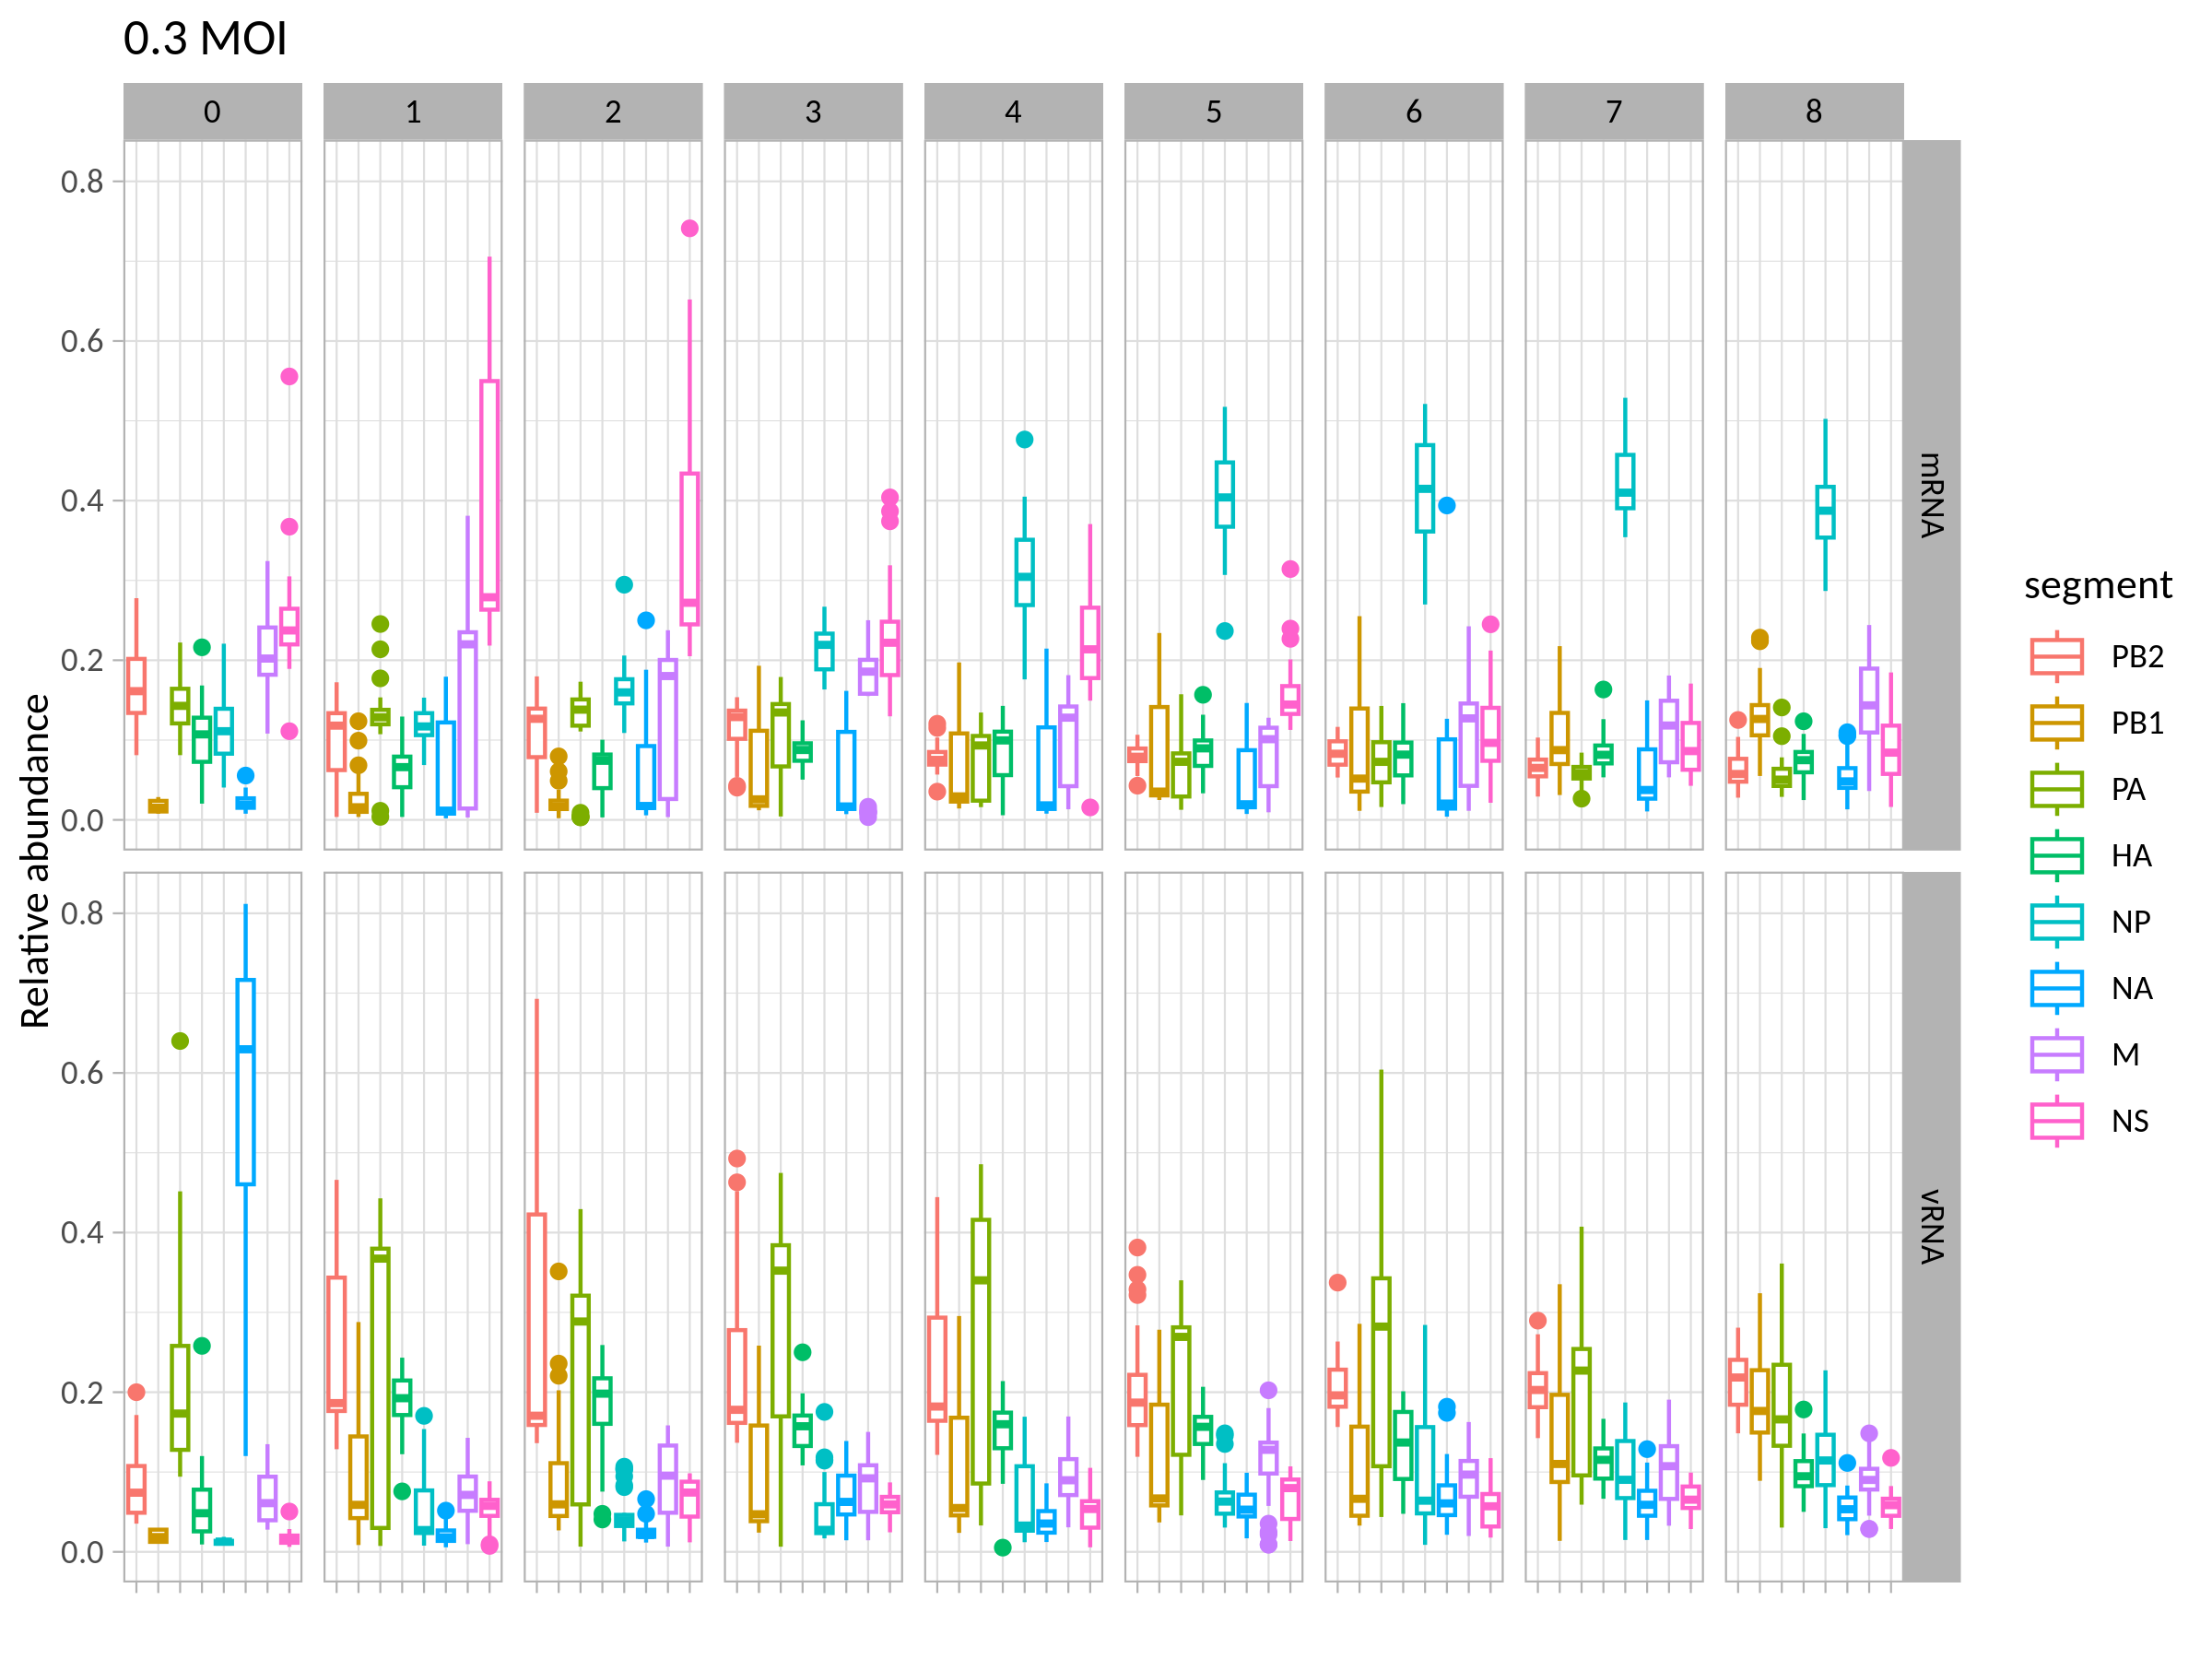

In [20]:
spots_summary %>%
	group_by(rep, moi, hpi, fov, molecule) %>%
	mutate(relative_abundance = spots_per_infected_cell/sum(spots_per_infected_cell)) %>%
	ungroup() %>%
	filter(moi==0.3, !is.na(molecule)) %>%
	mutate(segment = fct_relevel(segment, segment_order)) %>%
	ggplot(aes(x=segment, color=segment, y=relative_abundance)) +
		geom_boxplot() +
		facet_grid(molecule ~ hpi) +
		#geom_hline(yintercept=1/8, lty=2, lwd=.3) +
		theme(axis.text.x = element_blank()) +
		ggtitle("0.3 MOI") +
    ylab("Relative abundance") +
    xlab("")

In [21]:
ggsave("figures/supp-fig7b-relative_abundance_1.0MOI.svg", width = 8, height = 6, dpi = 300)

## <a id='toc1_5_'></a>[Spot types over time](#toc0_)

In [22]:
ambiguous_vs_unique <- spots_summary %>%
	ungroup() %>%
	mutate(barcode = case_when(
		segment=="multi" & ambiguous ~ "ambiguous",
		segment=="multi" ~ "multi",
		segment=="missing" ~ "missing",
		TRUE ~ "unique"
	)) %>%
	group_by(rep,moi,hpi,fov,barcode) %>%
	summarize(spots = sum(spots), spots_per_infected_cell = sum(spots_per_infected_cell)) %>%
	group_by(moi,hpi,barcode) %>%
  	mutate(mean_n = mean(spots_per_infected_cell)) %>%
	ungroup

`summarise()` has grouped output by 'rep', 'moi', 'hpi', 'fov'. You can
override using the `.groups` argument.


In [23]:
ambiguous_vs_unique_nucVScyt <- spots_summary_nucVScyt %>%
	ungroup() %>%
	mutate(barcode = case_when(
		segment=="multi" & ambiguous ~ "ambiguous",
		segment=="multi" ~ "multi",
		segment=="missing" ~ "missing",
		TRUE ~ "unique"
	)) %>%
	group_by(rep,moi,hpi,fov,barcode,nucleus) %>%
	summarize(spots = sum(spots), spots_per_infected_cell = sum(spots_per_infected_cell)) %>%
	group_by(moi,hpi,barcode,nucleus) %>%
  	mutate(mean_n = mean(spots_per_infected_cell)) %>%
	ungroup

`summarise()` has grouped output by 'rep', 'moi', 'hpi', 'fov', 'barcode'. You
can override using the `.groups` argument.


### <a id='toc1_5_1_'></a>[Ambiguous vs missing vs unique](#toc0_)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


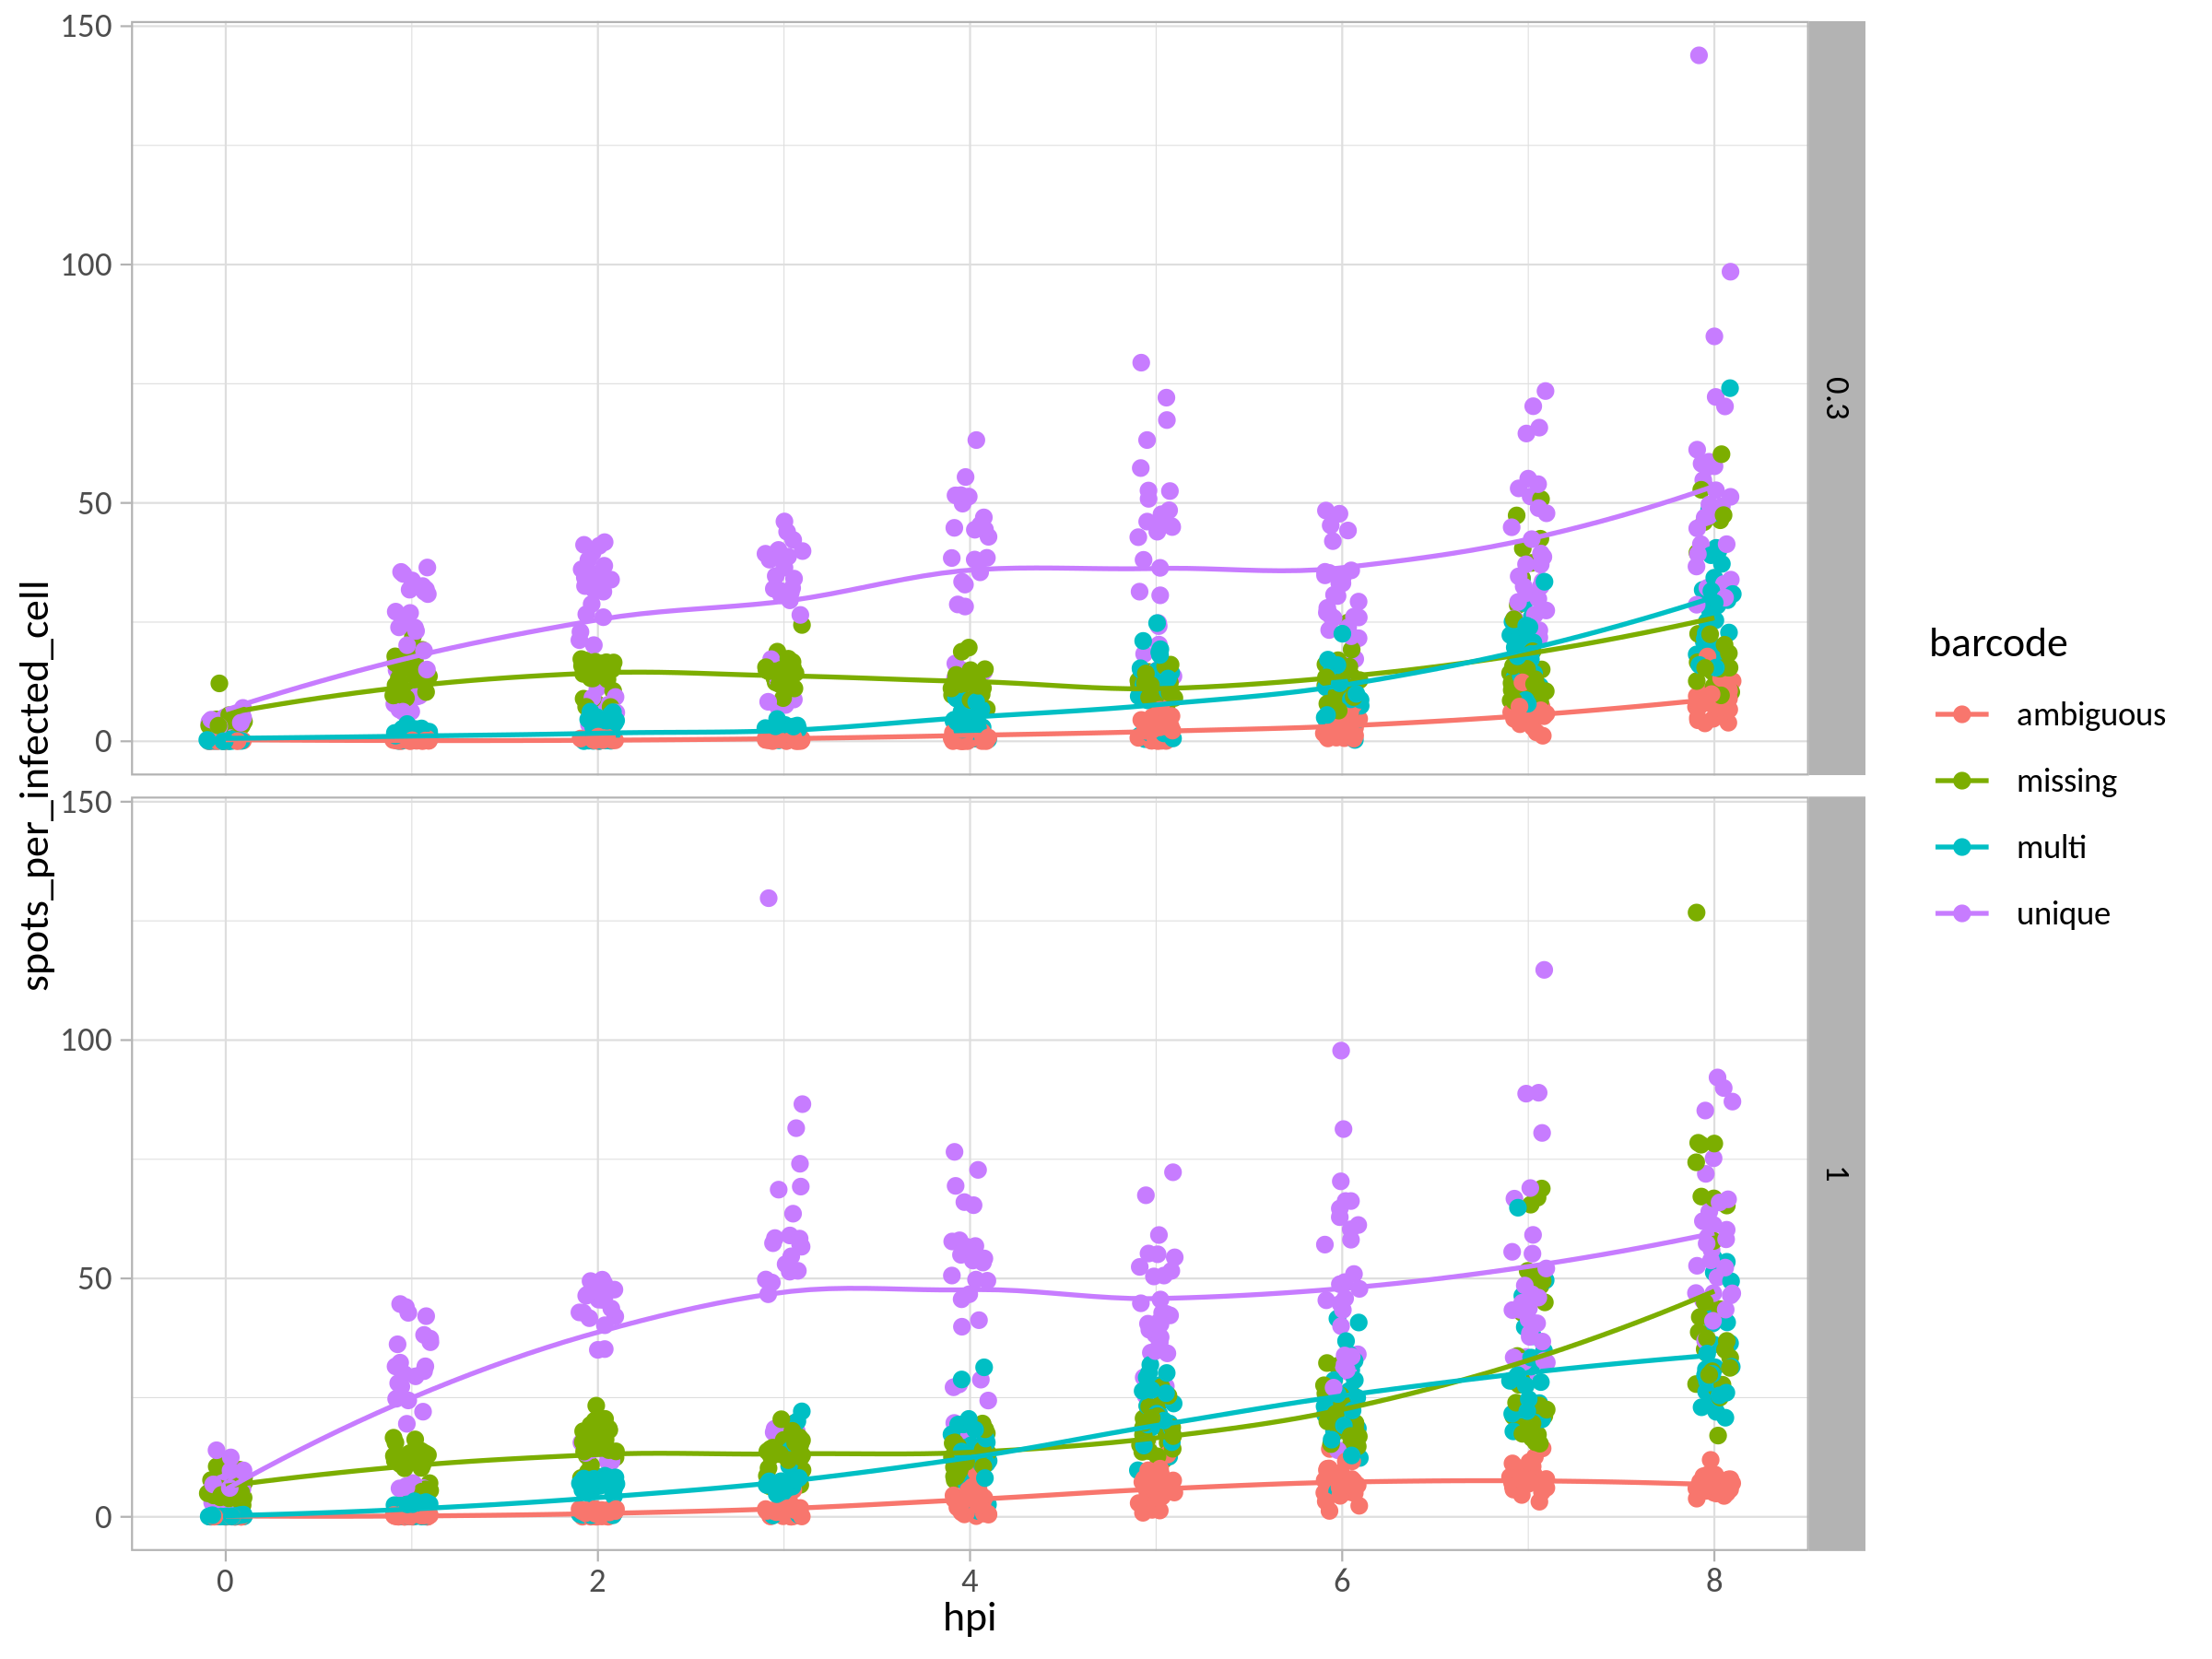

In [24]:
ambiguous_vs_unique %>%
	filter(moi>0) %>%
	ggplot(aes(x=hpi,y=spots_per_infected_cell,color=barcode)) +
		geom_jitter(height=0, width=.1) +
		geom_smooth(se=FALSE, lwd=.6) +
		#geom_line(aes(y=mean_n)) +
		facet_grid(moi ~ .)

In [25]:
spots %>% count(target, sort=TRUE) %>% head(20)

target,n
<chr>,<int>
missing,533270
NP mRNA,274642
NS mRNA,119770
M mRNA,113078
PA vRNA,74789
PB1 mRNA,71260
HA mRNA,68192
PB2 mRNA,66633
PA mRNA,65088


#### <a id='toc1_5_1_1_'></a>[Nucleus vs cytoplasm](#toc0_)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


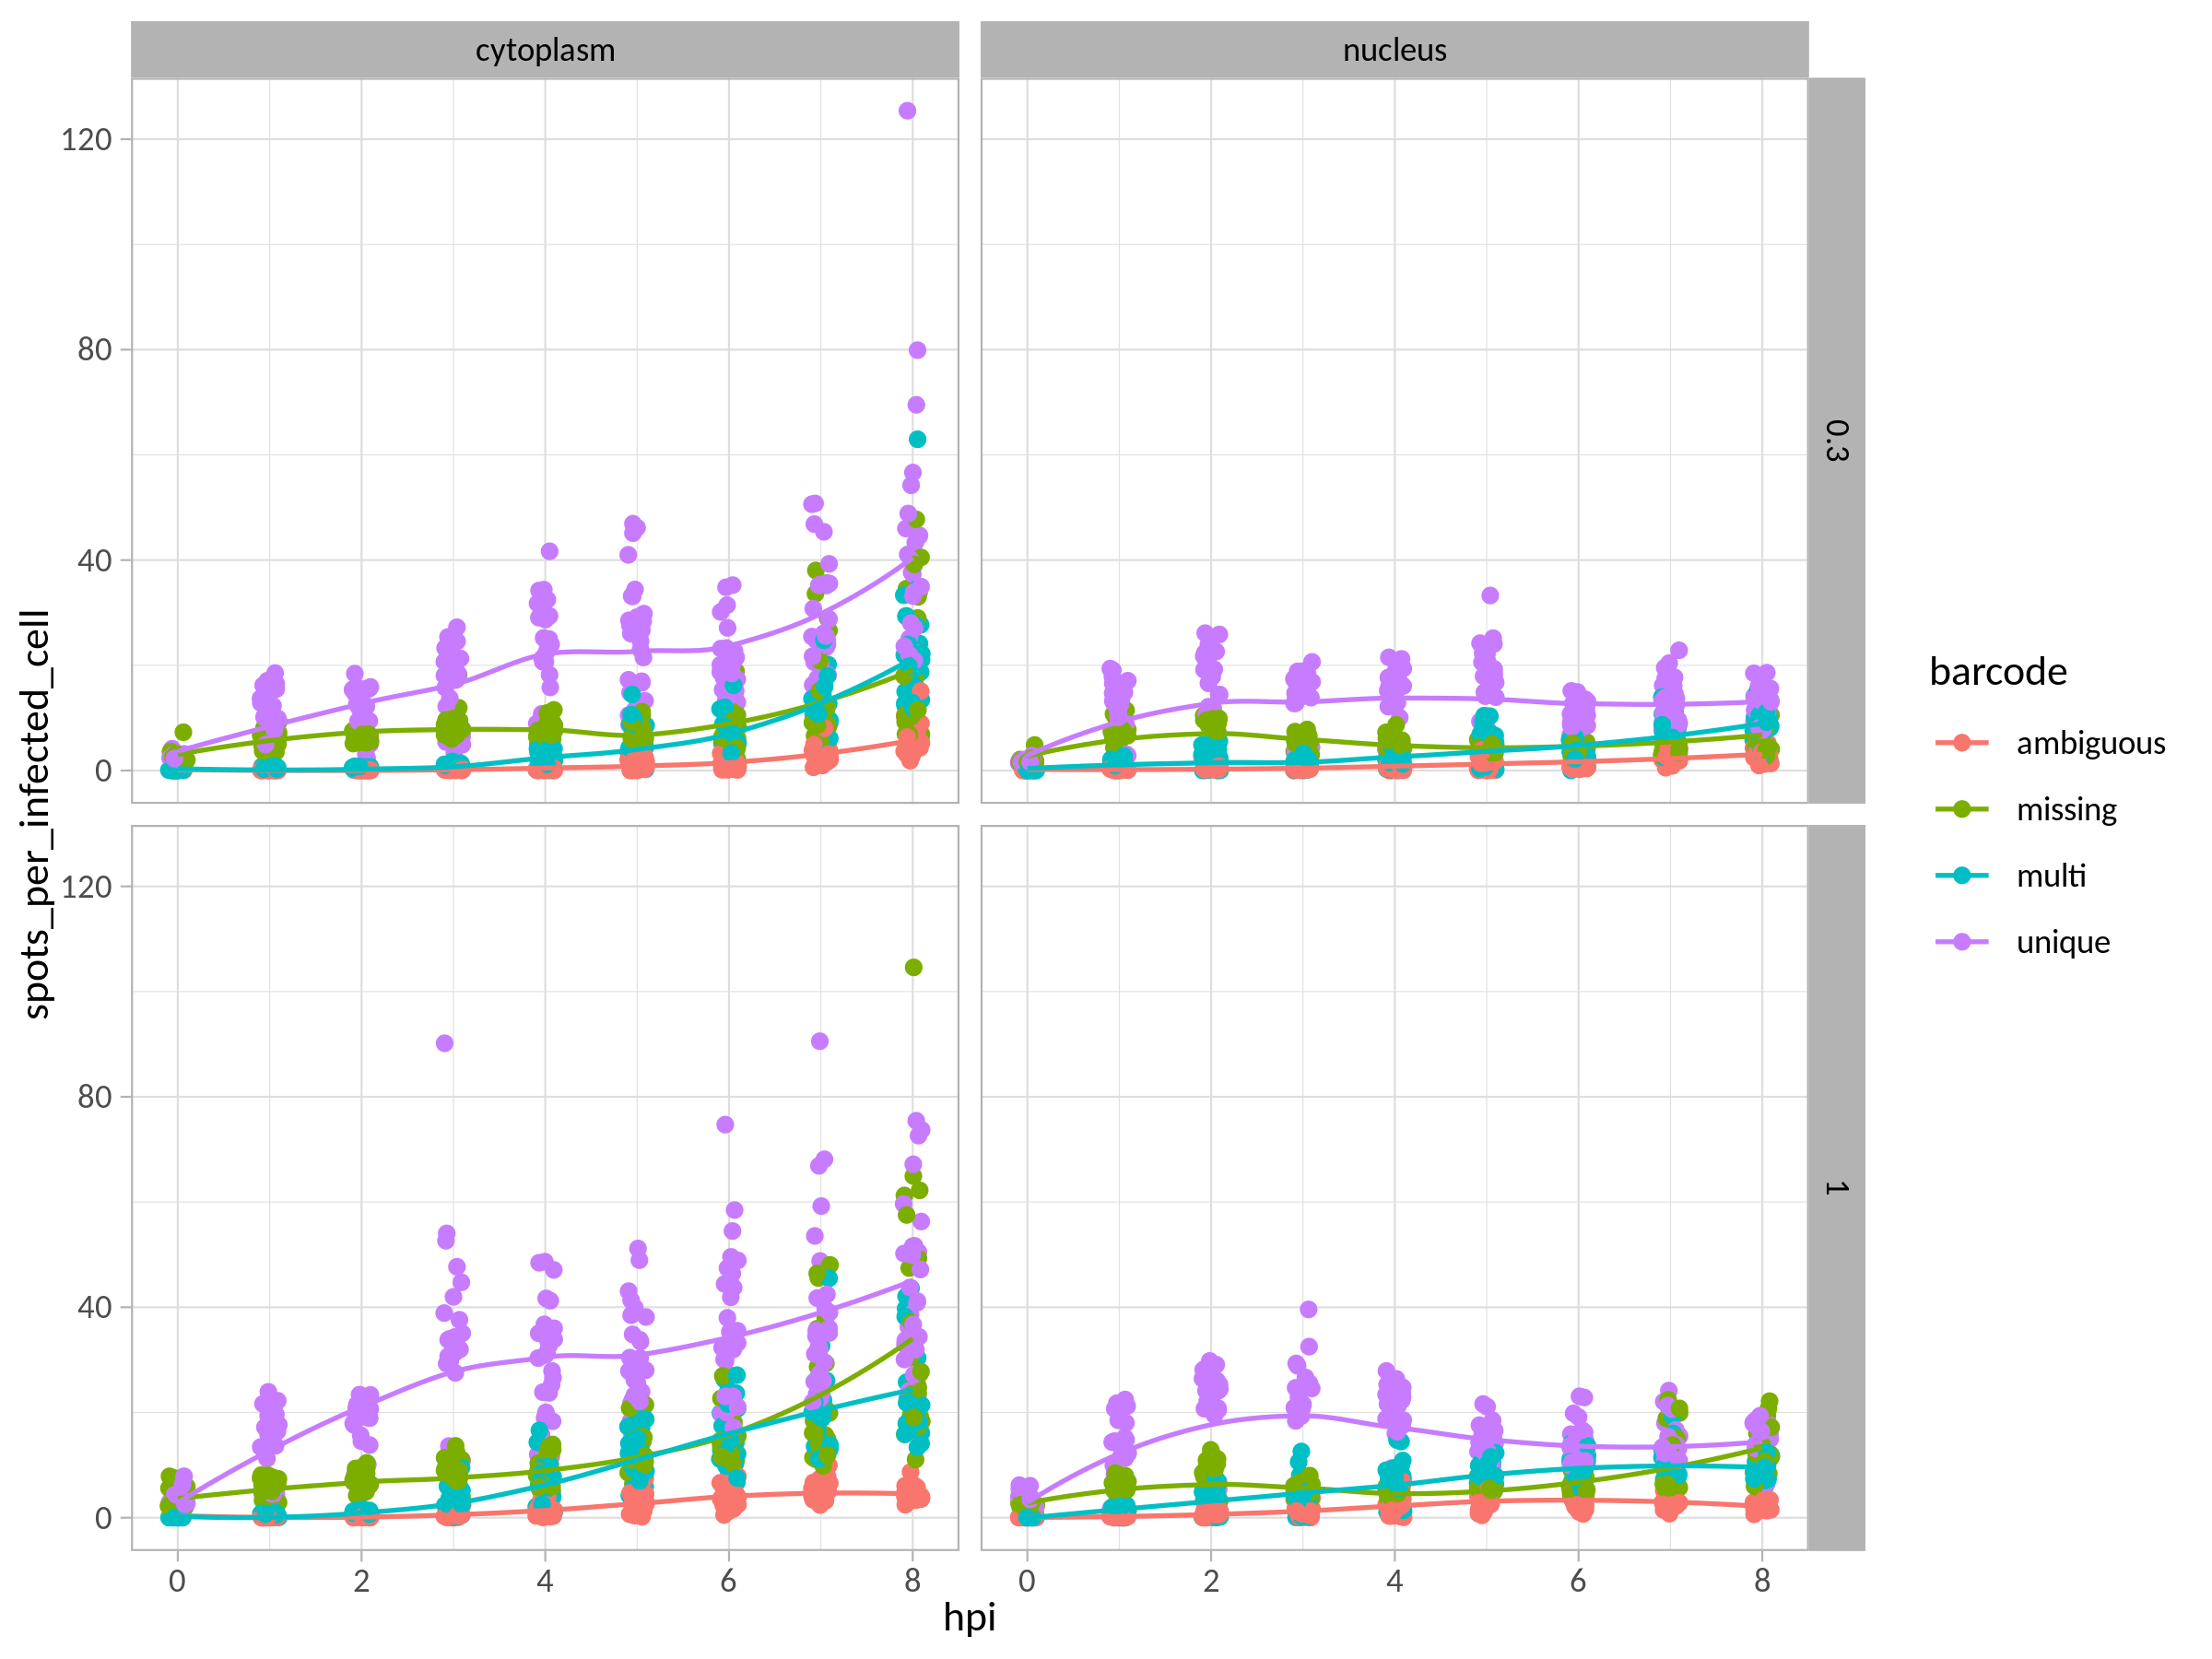

In [26]:
ambiguous_vs_unique_nucVScyt %>%
	filter(moi>0) %>%
	ggplot(aes(x=hpi,y=spots_per_infected_cell,color=barcode)) +
		geom_jitter(height=0, width=.1) +
		geom_smooth(se=FALSE, lwd=.6) +
		#geom_line(aes(y=mean_n)) +
		facet_grid(moi ~ nucleus)

### <a id='toc1_5_2_'></a>[Ambiguous vs unique](#toc0_)

#### <a id='toc1_5_2_1_'></a>[Nucleus vs cytoplasm](#toc0_)

We treat all multi spots as ambiguous here, as we don't trust this barcoding scheme to decipher complexes nor the pipeline to correctly identify activation patterns with more than one active channel per round.

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


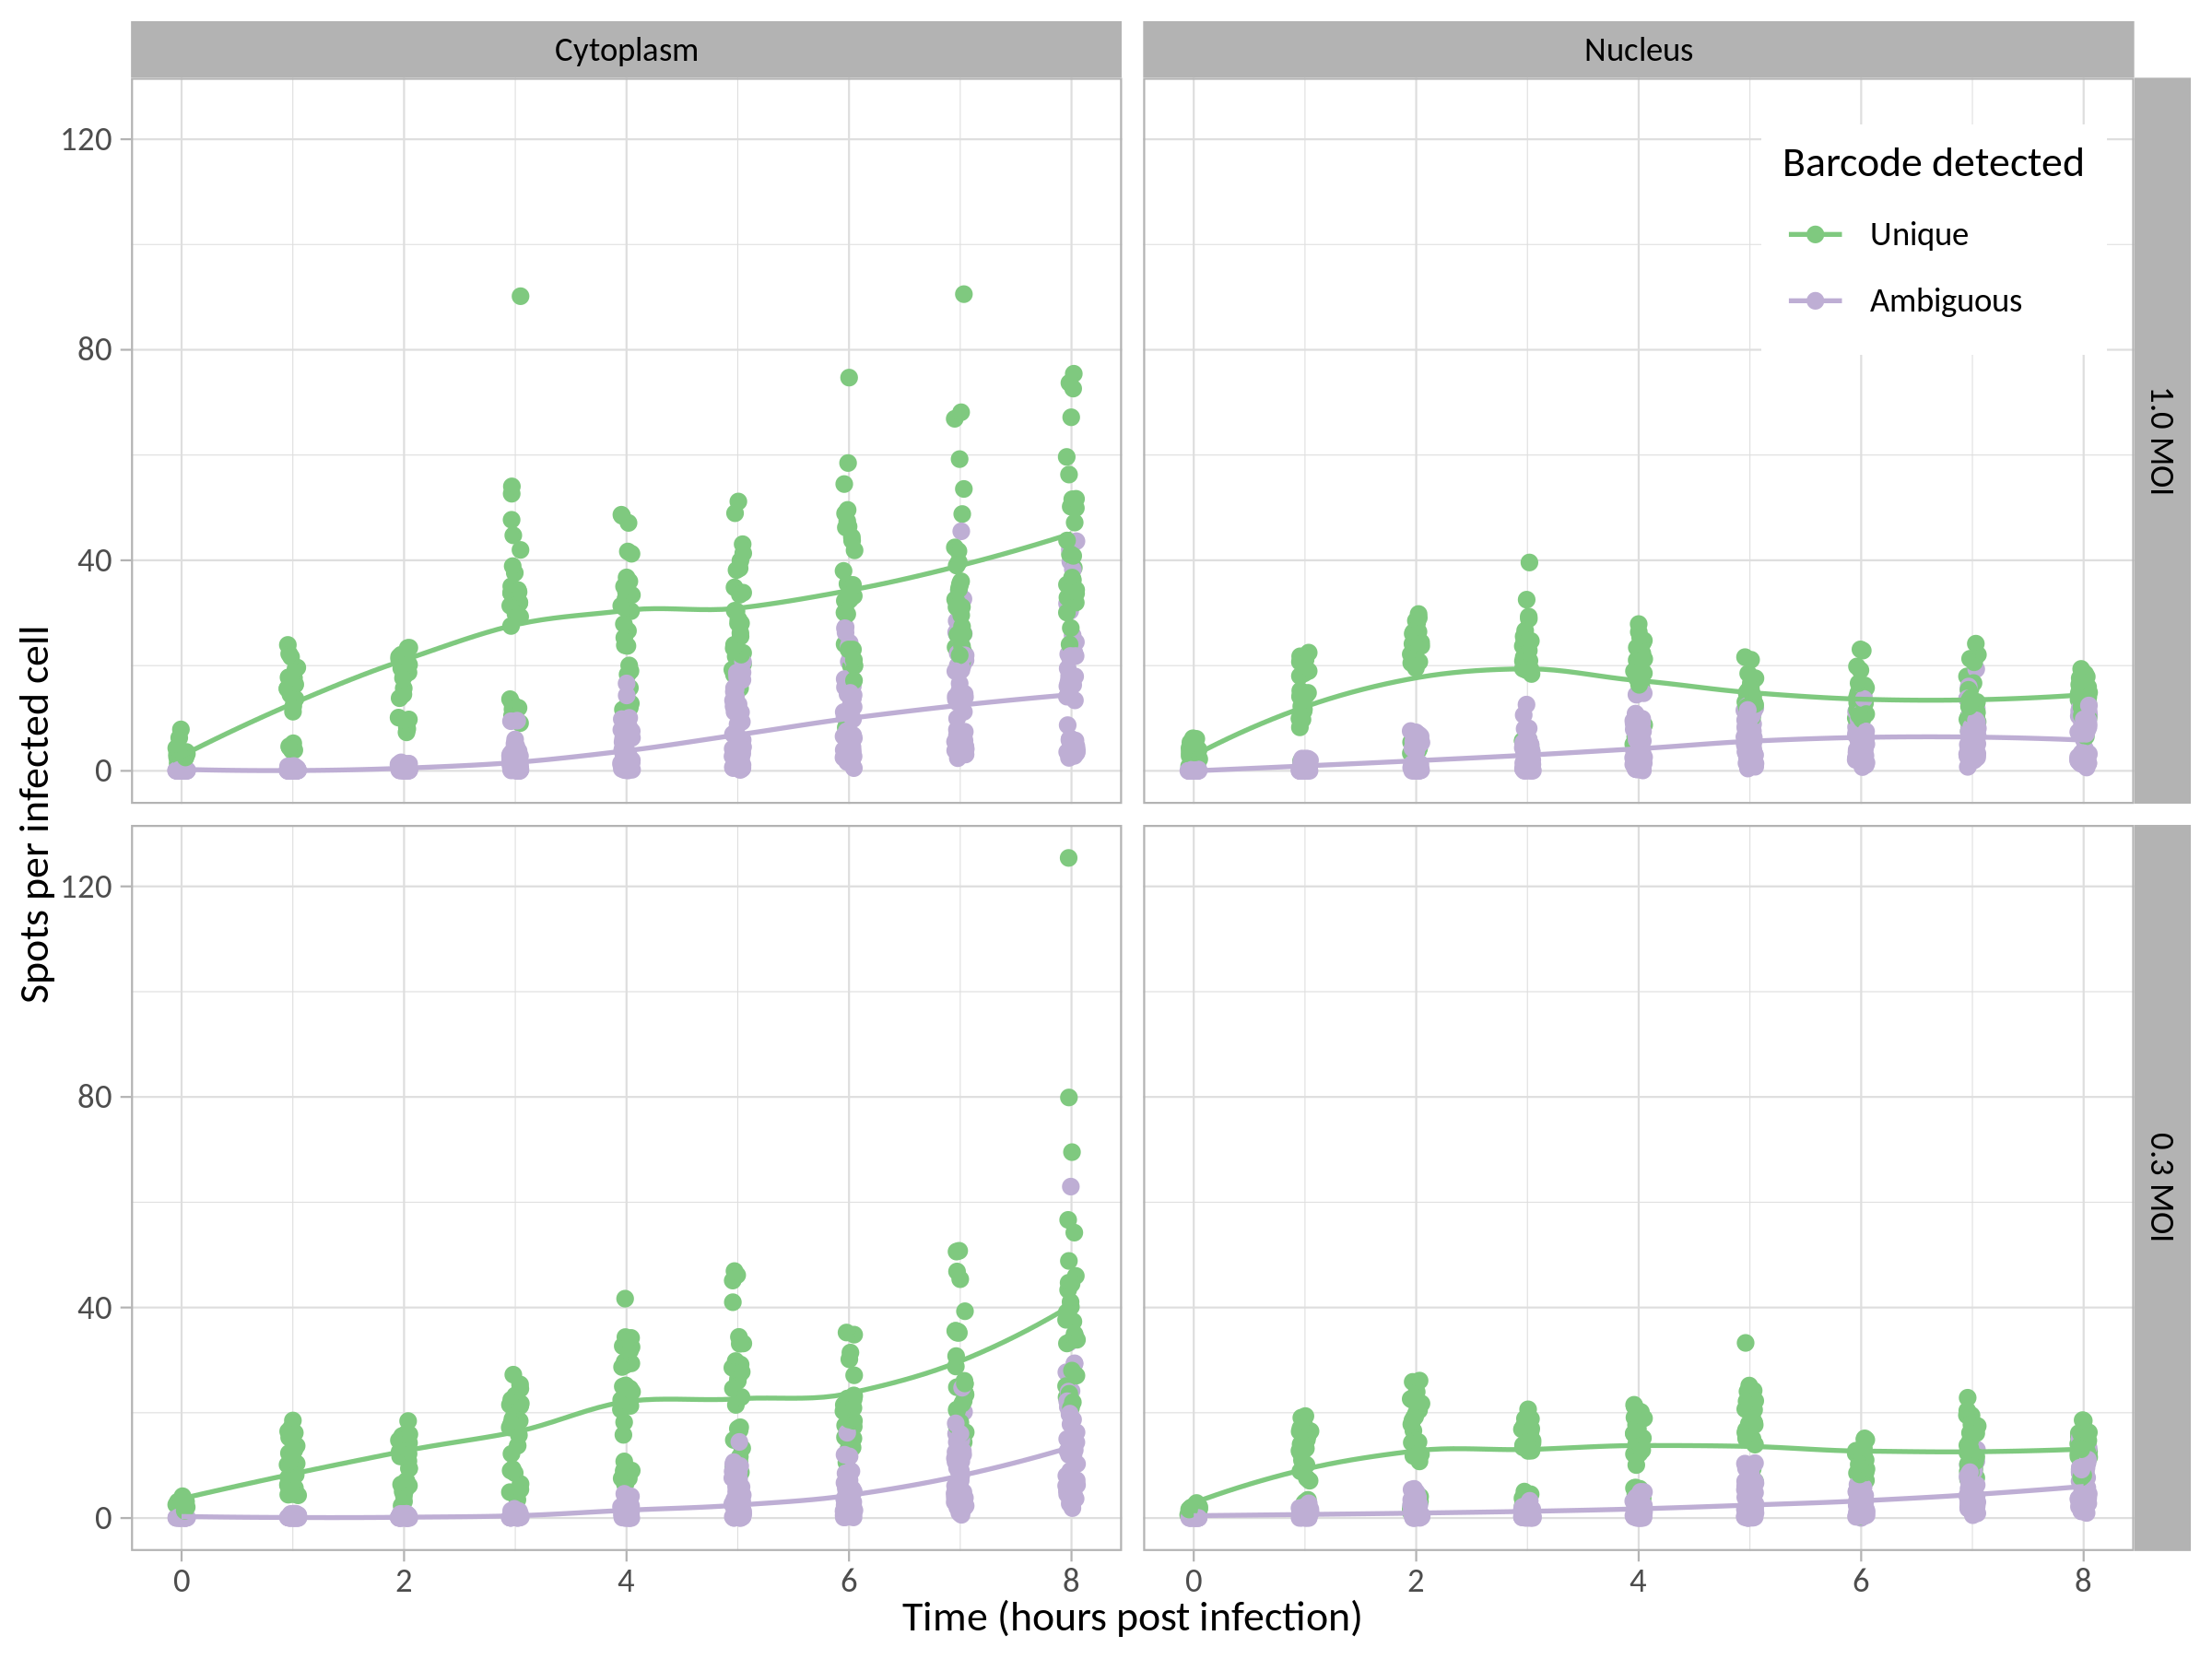

In [27]:
ambiguous_vs_unique_nucVScyt %>%
  mutate(
    barcode = if_else(barcode=="multi", "ambiguous", barcode),
    barcode = str_to_title(barcode),
    nucleus = str_to_title(nucleus),
    barcode=fct_relevel(barcode, "Unique"),
  ) %>%
	filter(moi>0, barcode != "Missing") %>%
  mutate(moi = str_glue("{format(moi, nsmall=1)} MOI"), moi=fct_rev(moi)) %T>%
  write_tsv("figures/supp-fig9a-ambiguous_vs_unique_nucCyto.tsv") %>%
	ggplot(aes(x=hpi,y=spots_per_infected_cell,color=barcode)) +
		geom_jitter(height=0, width=.05) +
		geom_smooth(se=FALSE, lwd=.6) +
		#geom_line(aes(y=mean_n)) +
		facet_grid(moi ~ nucleus) +
    scale_color_brewer(palette="Accent", name="Barcode detected") +
		theme(text = element_text(family = "Calibri"), strip.text = element_text(colour = 'black')) +
		theme(legend.position = c(.9,.89)) +
    xlab("Time (hours post infection)") +
    ylab("Spots per infected cell") +
    NULL

In [28]:
ggsave("figures/supp-fig9a-ambiguous_vs_unique_nucCyto.svg", width = 8, height = 6, dpi = 300)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


## <a id='toc1_6_'></a>[Type of multi spots](#toc0_)

`summarise()` has grouped output by 'moi', 'hpi', 'rna_type'. You can override
using the `.groups` argument.


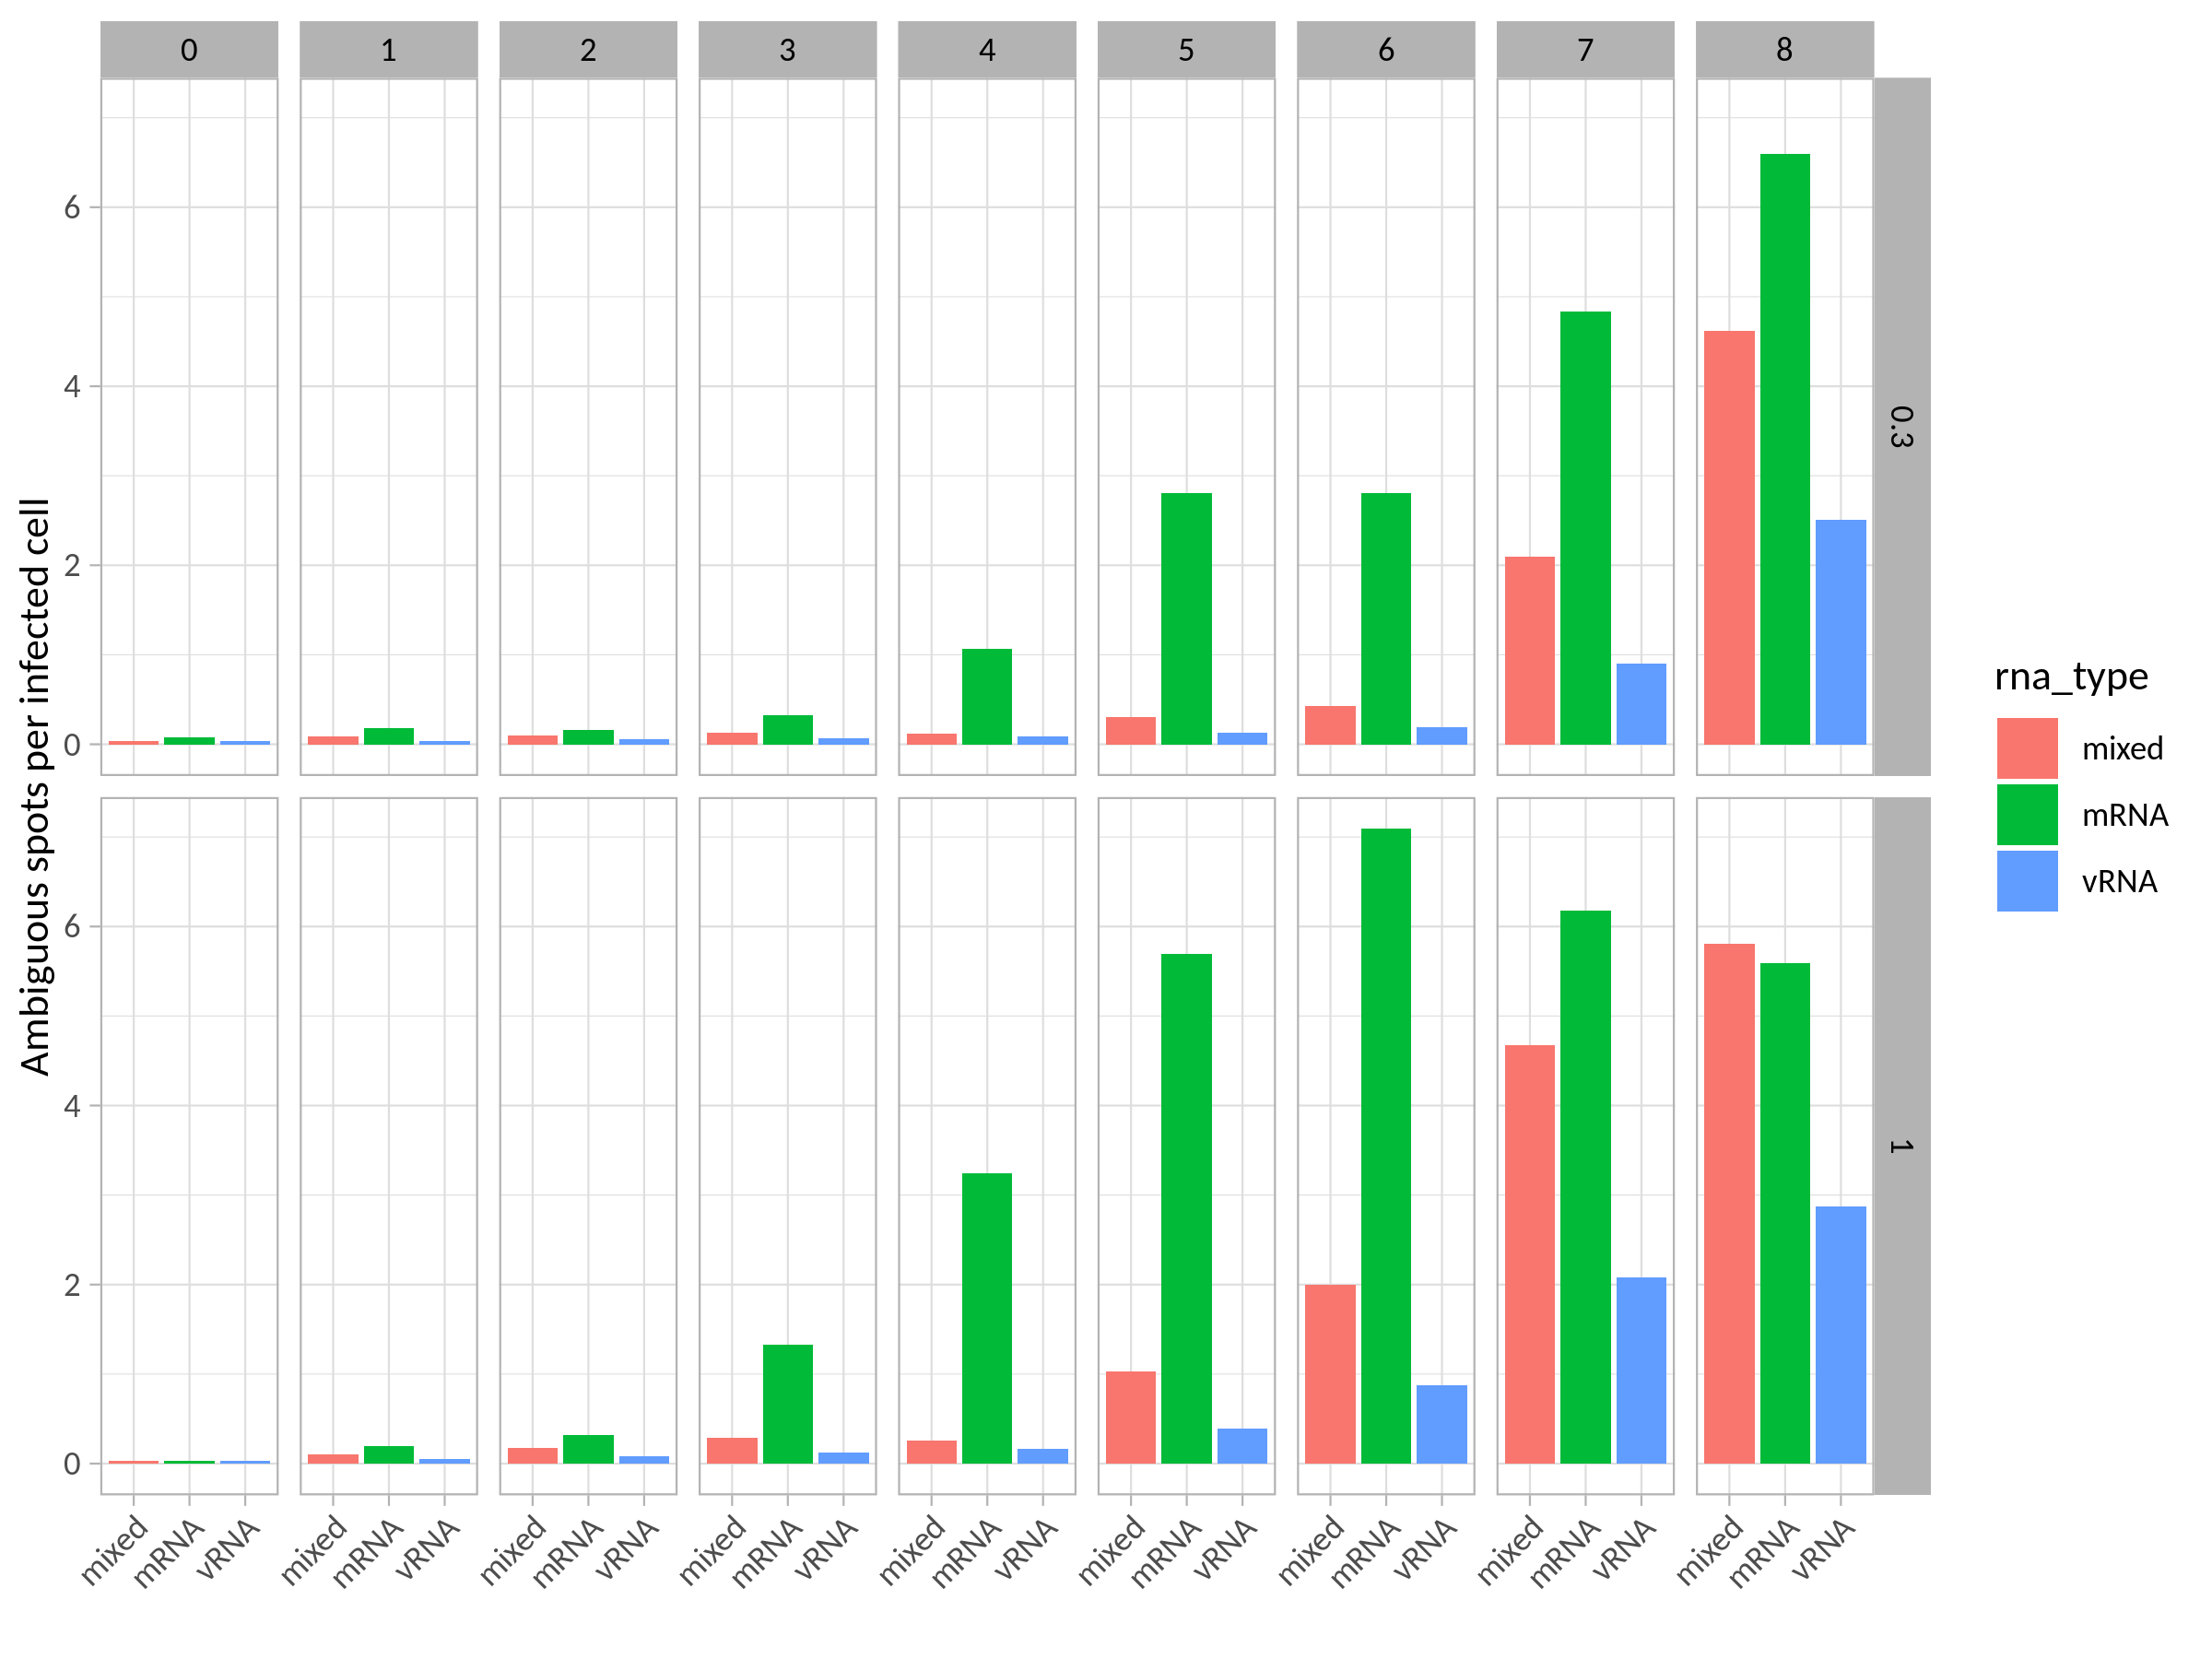

In [29]:
spots_summary_nucVScyt %>%
  filter(segment != "missing") %>%
  filter(nucleus=="cytoplasm") %>%
  group_by(moi,hpi,rna_type, segment) %>%
  summarize(spots_per_infected_cell = mean(spots_per_infected_cell)) %>%
  pivot_wider(names_from = segment, values_from = spots_per_infected_cell, values_fill=0) %>%
  ggplot(aes(rna_type, multi, fill=rna_type)) +
    geom_col() +
    facet_grid(moi ~ hpi) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    ylab("Ambiguous spots per infected cell") +
    xlab("")

In [30]:
ggsave("figures/supp-fig9b-spots_per_cell-cytoplasm-multi_spot.svg", width = 8, height = 6, dpi = 300)